# Imports & Setup

In [1]:
import warnings
warnings.filterwarnings("ignore")

import sys
import argparse
import math
from dataclasses import dataclass
from typing import Dict, Tuple, List, Optional, Callable, Any

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pandas_datareader import data as pdr
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from xgboost import XGBRegressor

import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.ar_model import AutoReg

In [2]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

ALPHA = 0.05

FRED_CODES = {
    "UNRATE": "UNRATE",
    "VIX": "VIXCLS",
    "TERM_SPREAD": "T10Y3M"
}

# Data Classes

In [3]:
@dataclass
class PointForecast:
    model_label: str
    version_type: str
    include_intervals: bool
    y_hat: float
    y_lo: float
    y_hi: float
    selected_columns: Optional[List[str]] = None
    selected_order: Optional[Tuple[int, int]] = None
    diagnostics: Optional[Dict[str, Any]] = None
    fitted: Optional[Any] = None

In [4]:
@dataclass
class ForecastRun:
    model_name: str
    y_true: pd.Series
    y_pred: pd.Series
    y_lo: pd.Series
    y_hi: pd.Series
    y_naive: pd.Series
    metrics: Dict[str, float]
    details: Dict[str, Any]

In [5]:
@dataclass
class SupervisedData:
    X: pd.DataFrame
    y: pd.Series
    feature_list: List[str]

# Utilities & Helpers

In [6]:
class DebugLogger:
    def __init__(
        self,
        enabled: bool
    ) -> None:
        self.enabled = bool(enabled)

    def log(
        self,
        header: str,
        info: Dict[str, Any]
    ) -> None:
        if not self.enabled:
            return
        print(f"[DEBUG] {header}")
        for k, v in info.items():
            print(f"  - {k}: {v}")

In [7]:
class DataValidator:
    def __init__(
        self,
        logger: DebugLogger,
        min_panel_months: int = 36
    ) -> None:
        self.logger = logger
        self.min_panel_months = int(min_panel_months)

    def _check_index(
        self,
        idx: pd.Index,
        name: str
    ) -> None:
        if not idx.is_monotonic_increasing:
            raise ValueError(f"{name} index is not monotonic increasing.")
        if idx.duplicated().any():
            raise ValueError(f"{name} index contains duplicates.")

    def _check_no_nan_inf_df(
        self,
        df: pd.DataFrame,
        name: str
    ) -> None:
        if df.isna().any().any():
            raise ValueError(f"{name} contains NaN values.")
        if np.isinf(df.values).any():
            raise ValueError(f"{name} contains infinite values.")

    def _check_no_nan_inf_series(
        self,
        s: pd.Series,
        name: str
    ) -> None:
        if s.isna().any():
            raise ValueError(f"{name} contains NaN values.")
        if np.isinf(s.values).any():
            raise ValueError(f"{name} contains infinite values.")

    def validate_panel(
        self,
        df: pd.DataFrame,
        required_cols: List[str]
    ) -> None:
        self._check_index(df.index, "Panel df")
        missing = [c for c in required_cols if c not in df.columns]
        if len(missing) > 0:
            raise ValueError(f"Panel missing required columns: {missing}")
        row_count = df.shape[0]
        if row_count < self.min_panel_months:
            raise ValueError(
                f"Panel has too few rows: {row_count} (<{self.min_panel_months}). "
                f"Try an earlier --start date."
            )
        self.logger.log(
            "validate_panel passed",
            {
                "rows": row_count,
                "cols": df.shape[1],
                "min_required": self.min_panel_months
            }
        )

    def validate_enriched_panel(
        self,
        df: pd.DataFrame
    ) -> None:
        self._check_index(df.index, "Enriched panel")
        self._check_no_nan_inf_df(df, "Enriched panel")
        self.logger.log(
            "validate_enriched_panel passed",
            {
                "rows": df.shape[0],
                "cols": df.shape[1],
                "start": str(df.index.min()),
                "end": str(df.index.max())
            }
        )

    def validate_supervised_raw(
        self,
        X: pd.DataFrame,
        y: pd.Series
    ) -> None:
        self._check_index(X.index, "Supervised X")
        self._check_index(y.index, "Supervised y")
        if not X.index.equals(y.index):
            self.logger.log(
                "validate_supervised_raw note",
                {"msg": "X and y indices differ; alignment will follow."}
            )

    def validate_supervised_ready(
        self,
        X: pd.DataFrame,
        y: pd.Series
    ) -> None:
        self._check_index(X.index, "Aligned X")
        self._check_index(y.index, "Aligned y")
        if not X.index.equals(y.index):
            raise ValueError("Aligned X and y indices are not identical.")
        self._check_no_nan_inf_df(X, "Aligned X")
        self._check_no_nan_inf_series(y, "Aligned y")
        if X.shape[0] < 60:
            raise ValueError(
                f"Aligned supervised set has too few rows: {X.shape[0]} (<60). Try an earlier --start date."
            )
        if X.shape[1] < 3:
            raise ValueError(
                f"Aligned supervised set has too few features: {X.shape[1]} (<3)."
            )
        self.logger.log(
            "validate_supervised_ready passed",
            {"rows": X.shape[0], "features": X.shape[1]}
        )

    def validate_endog_ready(
        self,
        endog: pd.DataFrame,
        required_cols: List[str]
    ) -> None:
        self._check_index(endog.index, "Endog")
        missing = [c for c in required_cols if c not in endog.columns]
        if len(missing) > 0:
            raise ValueError(f"Endog missing required columns: {missing}")
        self._check_no_nan_inf_df(endog, "Endog")
        if endog.shape[0] < 60:
            raise ValueError(
                f"Endog has too few rows: {endog.shape[0]} (<60). Try an earlier --start date."
            )
        self.logger.log(
            "validate_endog_ready passed",
            {"rows": endog.shape[0], "vars": endog.shape[1]}
        )

    def validate_ready_for_backtest(
        self,
        X: pd.DataFrame,
        y: pd.Series,
        base_warmup: int
    ) -> None:
        n_rows = len(X)
        n_features = X.shape[1]
        need_for_ols = n_features + 12
        need_floor = 72
        eff_start = max(base_warmup, need_for_ols, need_floor)
        eff_start = min(eff_start, n_rows - 1)
        test_points = n_rows - eff_start
        if test_points < 1:
            raise ValueError(
                f"Backtest would have zero test points (rows={n_rows}, features={n_features}, "
                f"base_warmup={base_warmup}, eff_start={eff_start}). Try an earlier --start or reduce --warmup."
            )
        self.logger.log(
            "validate_ready_for_backtest passed",
            {
                "rows": n_rows,
                "features": n_features,
                "effective_start": eff_start,
                "test_points": test_points
            }
        )

In [8]:
def aicc_from_ols_fit(
    fit_obj: sm.regression.linear_model.RegressionResultsWrapper
) -> float:
    n = int(fit_obj.nobs)
    k = int(fit_obj.df_model) + 1
    aic = float(fit_obj.aic)
    denom = max(1, n - k - 1)
    aicc = aic + (2 * k * (k + 1)) / denom
    aicc_result = float(aicc)
    return aicc_result

In [9]:
def parse_exclude_ranges(
    ranges_str: str
) -> List[Tuple[pd.Timestamp, pd.Timestamp]]:
    """
    Parse 'YYYY-MM:YYYY-MM;YYYY-MM:YYYY-MM;...' into list of (start_ts, end_ts) inclusive.
    Empty string -> [].
    """
    out: List[Tuple[pd.Timestamp, pd.Timestamp]] = []
    s = (ranges_str or "").strip()
    if not s:
        return out
    for chunk in s.split(";"):
        chunk = chunk.strip()
        if not chunk:
            continue
        if ":" not in chunk:
            continue
        a, b = chunk.split(":", 1)
        a_ts = pd.to_datetime(a.strip() + "-01")
        b_first = pd.to_datetime(b.strip() + "-01")
        b_last = (b_first + pd.offsets.MonthEnd(0))
        out.append((a_ts, b_last))
    parsed_result = out
    return parsed_result

In [10]:
def mask_exclude_by_ranges(
    index: pd.DatetimeIndex,
    ranges: List[Tuple[pd.Timestamp, pd.Timestamp]],
    invert: bool = True
) -> pd.Series:
    """
    Build a boolean mask for index based on 'ranges'.
    invert=True returns True for rows to KEEP (i.e., ~in_excluded).
    """
    if len(ranges) == 0:
        mask_result = pd.Series(True, index=index, dtype=bool)
        return mask_result
    in_any = pd.Series(False, index=index, dtype=bool)
    for a, b in ranges:
        in_any |= index.to_series().between(a, b)
    mask_result = (~in_any) if invert else in_any
    return mask_result

# Conformal Calibration

In [11]:
class CVPlusGlobalConformal:
    """
    CV+ style global conformal using TRAIN backtest OOS residuals:
      1) r = y_true_bt - yhat_bt
      2) mu = mean(r)                (de-bias)
      3) g = 1.4826 * MAD(r - mu)    (fallback to RMSE if MAD==0; floor to 1e-8)
      4) z = |(r - mu)/g|
      5) q = finite-sample rank quantile of z at (1 - alpha)
      Band for yhat*:  (yhat* + mu) +/- q*g

    Strategy hooks:
    - time filter: exclude specified dates before computing mu, g, q
    - winsorize: clip z at winsor_cap before quantile
    """

    def __init__(
        self,
        alpha: float = 0.05
    ):
        self.alpha = float(alpha)
        self.mu_: Optional[float] = None
        self.g_: Optional[float] = None
        self.q_: Optional[float] = None

    @staticmethod
    def _robust_scale(
        centered: np.ndarray
    ) -> float:
        mad = float(np.median(np.abs(centered))) if centered.size > 0 else 0.0
        if mad > 0.0:
            robust_result = float(1.4826 * mad)
            return robust_result
        rmse = float(np.sqrt(np.mean(centered ** 2))) if centered.size > 0 else 0.0
        if not np.isfinite(rmse) or rmse <= 0.0:
            rmse = 1e-8
        rmse_result = rmse
        return rmse_result

    def fit_from_backtest(
        self,
        y_true_series: pd.Series,
        y_pred_series: pd.Series,
        exclude_mask: Optional[pd.Series] = None,
        winsor_cap: Optional[float] = None
    ) -> Tuple[float, float, float]:
        # Align and (optionally) filter
        y_true_series = y_true_series.copy()
        y_pred_series = y_pred_series.copy()
        if exclude_mask is not None:
            y_true_series = y_true_series[exclude_mask]
            y_pred_series = y_pred_series[exclude_mask]

        r = y_true_series.values.astype(float) - y_pred_series.values.astype(float)
        mu = float(np.mean(r)) if r.size > 0 else 0.0
        centered = r - mu
        g = self._robust_scale(centered)
        z = np.abs(centered / g)

        if winsor_cap is not None and np.isfinite(winsor_cap) and winsor_cap > 0:
            z = np.minimum(z, float(winsor_cap))

        n = int(len(z))
        k = int(np.ceil((n + 1) * (1.0 - self.alpha)))
        k = max(1, min(k, n)) if n > 0 else 1
        q = float(np.partition(z, k - 1)[k - 1]) if n > 0 else 0.0
        self.mu_, self.g_, self.q_ = mu, g, q
        fit_result = (self.mu_, self.g_, self.q_)
        return fit_result

    def interval_for_point(
        self,
        yhat_point: float
    ) -> Tuple[float, float, float]:
        assert self.mu_ is not None and self.g_ is not None and self.q_ is not None, "Calibrator not fitted."
        y_center = float(yhat_point) + self.mu_
        half = float(self.q_ * self.g_)
        interval_result = (y_center, y_center - half, y_center + half)
        return interval_result

# Data Processing

In [12]:
class DataBuilder:
    def __init__(
        self,
        start: str,
        logger: DebugLogger,
        release_mode: str = "conservative",
        exogs: Optional[List[str]] = None
    ) -> None:
        self.start = start
        self.logger = logger
        self.release_mode = release_mode
        default_exogs = ["VIX", "TERM_SPREAD"]
        self.exogs = exogs if exogs is not None else default_exogs

    def _load_series(
        self,
        code: str
    ) -> pd.Series:
        s = pdr.DataReader(code, "fred", start=self.start)
        s2 = s.squeeze("columns")
        s2.name = code
        return s2

    def _release_lag_map(
        self,
        mode: str
    ) -> Dict[str, int]:
        # Monthly aggregation already avoids same-month peeking for target
        # For exogs, set lag map here if simulating later releases
        map_result = {"VIX": 0, "TERM_SPREAD": 0}
        return map_result

    def _apply_release_realism(
        self,
        df_base: pd.DataFrame
    ) -> pd.DataFrame:
        lag_map = self._release_lag_map(self.release_mode)
        df = df_base.copy()
        for col, lag in lag_map.items():
            if col in df.columns and lag > 0:
                df[col] = df[col].shift(lag)
        return df

    @staticmethod
    def _nber_recession_dummy(
        idx: pd.DatetimeIndex
    ) -> pd.Series:
        rec_ranges = [
            ("1990-07", "1991-03"),
            ("2001-03", "2001-11"),
            ("2007-12", "2009-06"),
            ("2020-02", "2020-04"),
        ]
        s = pd.Series(0, index=idx, dtype=int)
        for a, b in rec_ranges:
            s.loc[
                (s.index >= pd.to_datetime(a)) & (s.index <= pd.to_datetime(b))
            ] = 1
        s.name = "REC"
        return s

    @staticmethod
    def _pandemic_flag(
        idx: pd.DatetimeIndex
    ) -> pd.Series:
        s = pd.Series(0, index=idx, dtype=int)
        s.loc[
            (s.index >= pd.to_datetime("2020-03-01")) & (s.index <= pd.to_datetime("2021-12-31"))
        ] = 1
        s.name = "PANDEMIC"
        return s

    def build_monthly_panel(
        self
    ) -> pd.DataFrame:
        y = self._load_series(FRED_CODES["UNRATE"]).resample("M").last()
        vix = self._load_series(FRED_CODES["VIX"]).resample("M").mean()
        term = self._load_series(FRED_CODES["TERM_SPREAD"]).resample("M").last()

        base_df = pd.concat(
            [
                y.rename("UNRATE"),
                vix.rename("VIX"),
                term.rename("TERM_SPREAD")
            ],
            axis=1
        ).sort_index()

        release_df = self._apply_release_realism(base_df)

        df = release_df.copy()
        t = np.arange(len(df), dtype=float)
        df["t"] = t

        df["REC"] = self._nber_recession_dummy(df.index)
        df["PANDEMIC"] = self._pandemic_flag(df.index)

        df_final = df.dropna().copy()

        self.logger.log(
            "build_monthly_panel raw",
            {
                "rows": df_final.shape[0],
                "cols": df_final.shape[1],
                "start": str(df_final.index.min()),
                "end": str(df_final.index.max())
            }
        )
        self.logger.log(
            "build_monthly_panel final",
            {"rows": df_final.shape[0], "cols": df_final.shape[1]}
        )
        return df_final

    def make_supervised(
        self,
        df: pd.DataFrame,
        y_col: str = "UNRATE",
        y_lags: int = 3,
        include_exogs: bool = True,
        include_trend: bool = True,
        for_xgb_extras: bool = False
    ) -> SupervisedData:
        data = df.copy()

        # UNRATE lags
        y_lags = int(max(1, y_lags))
        for L in range(1, y_lags + 1):
            data[f"{y_col}_L{L}"] = data[y_col].shift(L)

        # Exogenous lag-1 only
        exog_cols = (
            [c for c in ["VIX", "TERM_SPREAD"] if c in data.columns]
            if include_exogs else []
        )
        for col in exog_cols:
            data[f"{col}_L1"] = data[col].shift(1)

        # Deterministic trend: already present as 't'
        if include_trend and "t" in data.columns:
            pass

        # XGB extras only
        if for_xgb_extras:
            data["D_UNRATE_L1"] = data["UNRATE"].diff(1).shift(1)
            for L in range(2, min(6, y_lags) + 1):
                data[f"D_UNRATE_L{L}"] = data["UNRATE"].diff(1).shift(L)
            if "REC" in data.columns:
                data["REC_L1"] = data["REC"].shift(1)
            if "PANDEMIC" in data.columns:
                data["PANDEMIC_L1"] = data["PANDEMIC"].shift(1)

        # Target is 1-step ahead
        data["TARGET_TPLUS1"] = data[y_col].shift(-1)

        keep_cols = []
        for L in range(1, y_lags + 1):
            keep_cols.append(f"{y_col}_L{L}")
        for col in exog_cols:
            keep_cols.append(f"{col}_L1")
        if include_trend:
            keep_cols.append("t")
        if for_xgb_extras:
            keep_cols += [c for c in data.columns if c.startswith("D_UNRATE_L")]
            if "REC_L1" in data.columns:
                keep_cols.append("REC_L1")
            if "PANDEMIC_L1" in data.columns:
                keep_cols.append("PANDEMIC_L1")

        X_full = data[keep_cols]
        X = X_full.dropna()
        y = data.loc[X.index, "TARGET_TPLUS1"]

        supervised = SupervisedData(X=X, y=y, feature_list=keep_cols)
        return supervised

# Metrics Computation

In [13]:
class MetricsCalculator:
    @staticmethod
    def compute_basic(
        y_true: pd.Series,
        y_pred: pd.Series,
        y_naive: pd.Series
    ) -> Dict[str, float]:
        mae_val = mean_absolute_error(y_true, y_pred)
        rmse_val = math.sqrt(mean_squared_error(y_true, y_pred))
        r2_val = r2_score(y_true, y_pred)
        mse_model = mean_squared_error(y_true, y_pred)
        mse_naive = mean_squared_error(y_true, y_naive)
        r2_vs_naive = 1.0 - (mse_model / mse_naive) if mse_naive > 0 else float("nan")
        mae_naive = mean_absolute_error(y_true, y_naive)
        mase_val = mae_val / mae_naive if mae_naive > 0 else float("nan")
        out = {
            "MAE": float(mae_val),
            "RMSE": float(rmse_val),
            "R2": float(r2_val),
            "R2_OOS_vs_Naive": float(r2_vs_naive),
            "MASE": float(mase_val)
        }
        metrics_result = out
        return metrics_result

    @staticmethod
    def compute_intervals(
        y_true: pd.Series,
        y_lo: pd.Series,
        y_hi: pd.Series
    ) -> Dict[str, float]:
        if y_lo.isna().all() or y_hi.isna().all():
            intervals_result = {"PI_Coverage": float("nan"), "PI_Avg_Width": float("nan")}
            return intervals_result
        inside = ((y_true >= y_lo) & (y_true <= y_hi)).astype(float)
        coverage_val = float(inside.mean()) if len(inside) > 0 else float("nan")
        width_val = float((y_hi - y_lo).mean()) if len(y_lo) > 0 else float("nan")
        intervals_result = {"PI_Coverage": coverage_val, "PI_Avg_Width": width_val}
        return intervals_result

# Point Forecasters

In [14]:
class AR1Forecaster:
    def __init__(
        self,
        engine: str,
        include_intervals: bool,
        logger: DebugLogger
    ) -> None:
        self.engine = engine
        self.include_intervals = include_intervals
        self.logger = logger

    @staticmethod
    def _fit_ols_phi_const(
        y_fit: pd.Series
    ) -> Tuple[float, float]:
        y_lag = y_fit.shift(1).dropna()
        y_t = y_fit.loc[y_lag.index]
        X = np.column_stack(
            [
                np.ones((len(y_lag), 1), dtype=float),
                y_lag.values.reshape(-1, 1)
            ]
        )
        ols = sm.OLS(y_t.values, X).fit()
        const = float(ols.params[0])
        phi = float(ols.params[1])
        param_result = (const, phi)
        return param_result

    def forecast(
        self,
        y_train: pd.Series
    ) -> PointForecast:
        const, phi = self._fit_ols_phi_const(y_train)
        yhat_base = const + phi * float(y_train.iloc[-1])
        pf = PointForecast(
            model_label="AR(1)",
            version_type=self.engine,
            include_intervals=False,
            y_hat=float(yhat_base),
            y_lo=np.nan,
            y_hi=np.nan,
            diagnostics={"phi": phi, "const": const}
        )
        self.logger.log("AR(1) point forecast", {"y_hat": pf.y_hat})
        return pf

In [15]:
class ARDLForecaster:
    def __init__(
        self,
        spec_mode: str,
        penalty: str,
        include_intervals: bool,
        logger: DebugLogger,
        max_p: int = 3,
        max_q: int = 1,
        ridge_alpha: float = 3.0
    ) -> None:
        self.spec_mode = spec_mode
        self.penalty = penalty
        self.include_intervals = include_intervals
        self.logger = logger
        self.max_p = int(max_p)
        self.max_q = int(max_q)
        self.ridge_alpha = float(ridge_alpha)

    @staticmethod
    def _infer_bases(
        X_cols: List[str]
    ) -> List[str]:
        bases = set()
        for c in X_cols:
            if c.startswith("UNRATE_L"):
                continue
            if c.endswith("_L1"):
                bases.add(c[:-3])
        sorted_bases = sorted(bases)
        return sorted_bases

    def _cols_for_order(
        self,
        X_block: pd.DataFrame,
        p: int,
        q: int,
        bases: List[str]
    ) -> List[str]:
        cols = [f"UNRATE_L{l}" for l in range(1, p + 1)]
        for b in bases:
            col_name = f"{b}_L1"
            if (col_name in X_block.columns) and (q >= 1):
                cols.append(col_name)
        if "t" in X_block.columns:
            cols.append("t")
        cols_result = cols
        return cols_result

    def _fixed_cols(
        self,
        X_block: pd.DataFrame
    ) -> List[str]:
        wanted = [
            "UNRATE_L1",
            "UNRATE_L2",
            "UNRATE_L3",
            "VIX_L1",
            "TERM_SPREAD_L1",
            "t"
        ]
        cols = [c for c in wanted if c in X_block.columns]
        cols_result = cols
        return cols_result

    def _select_by_aicc_on_train(
        self,
        X_fit: pd.DataFrame,
        y_fit: pd.Series
    ) -> Tuple[List[str], Tuple[int, int], float]:
        available_y_lags = sorted(
            [int(c.split("_L")[1]) for c in X_fit.columns if c.startswith("UNRATE_L")]
        )
        max_p_cap = min(self.max_p, max(available_y_lags) if len(available_y_lags) > 0 else 1)
        bases = self._infer_bases(list(X_fit.columns))

        best_aicc = np.inf
        best_pq = (1, 0)
        best_cols = []

        p_grid = list(range(1, max_p_cap + 1))
        q_grid = [0, 1]

        for p in p_grid:
            for q in q_grid:
                cols_try = self._cols_for_order(X_fit, p, q, bases)
                cols_use = [c for c in cols_try if c in X_fit.columns]
                if len(cols_use) == 0:
                    continue
                Xtr_vals = X_fit[cols_use].values
                ones_tr = np.ones((Xtr_vals.shape[0], 1), dtype=float)
                Xtr_mat = np.column_stack([ones_tr, Xtr_vals])
                ytr_vec = y_fit.values
                try:
                    fit_try = sm.OLS(ytr_vec, Xtr_mat).fit()
                    aicc_val = aicc_from_ols_fit(fit_try)
                    if aicc_val < best_aicc:
                        best_aicc = aicc_val
                        best_pq = (p, q)
                        best_cols = cols_use
                except Exception:
                    continue

        selected_result = (best_cols, best_pq, float(best_aicc))
        return selected_result

    def _ridge_fit(
        self,
        X_fit: pd.DataFrame,
        y_fit: pd.Series,
        cols: List[str]
    ) -> Tuple[Ridge, StandardScaler]:
        scaler = StandardScaler()
        X_fit_vals = scaler.fit_transform(X_fit[cols])
        ridge = Ridge(
            alpha=self.ridge_alpha,
            fit_intercept=True,
            random_state=RANDOM_STATE
        )
        fitted = ridge.fit(X_fit_vals, y_fit.values)
        ridge_result = (fitted, scaler)
        return ridge_result

    def _ols_fit(
        self,
        X_fit: pd.DataFrame,
        y_fit: pd.Series,
        cols: List[str]
    ) -> Tuple[sm.OLS, StandardScaler]:
        scaler = StandardScaler()
        X_fit_vals = scaler.fit_transform(X_fit[cols])
        ones_tr = np.ones((X_fit_vals.shape[0], 1), dtype=float)
        Xtr_mat = np.column_stack([ones_tr, X_fit_vals])
        ytr_vec = y_fit.values
        ols_fit = sm.OLS(ytr_vec, Xtr_mat).fit()
        ols_result = (ols_fit, scaler)
        return ols_result

    def forecast(
        self,
        X_train: pd.DataFrame,
        y_train: pd.Series,
        X_test: pd.DataFrame
    ) -> PointForecast:
        if self.spec_mode == "fixed":
            sel_cols = self._fixed_cols(X_train)
            sel_pq = (3, 1)
            sel_aicc = np.nan
        else:
            sel_cols, sel_pq, sel_aicc = self._select_by_aicc_on_train(X_train, y_train)
            if len(sel_cols) == 0:
                y_hat_val = float(y_train.iloc[-1])
                pf_empty = PointForecast(
                    model_label="ARDL",
                    version_type=f"{self.spec_mode}/{self.penalty}",
                    include_intervals=False,
                    y_hat=y_hat_val,
                    y_lo=np.nan,
                    y_hi=np.nan,
                    selected_columns=[],
                    selected_order=(0, 0),
                    diagnostics={"fallback": "no_columns"},
                    fitted=None
                )
                return pf_empty

        if self.penalty == "ridge":
            model_fit, scaler = self._ridge_fit(X_train, y_train, sel_cols)
            is_ols = False
        else:
            model_fit, scaler = self._ols_fit(X_train, y_train, sel_cols)
            is_ols = True

        Xte_vals = scaler.transform(X_test[sel_cols])
        base_hat = float(
            model_fit.predict(
                Xte_vals if not is_ols else np.column_stack(
                    [
                        np.ones((Xte_vals.shape[0], 1), dtype=float),
                        Xte_vals
                    ]
                )
            )[0]
        )

        pf = PointForecast(
            model_label="ARDL",
            version_type=f"{self.spec_mode}/{self.penalty}",
            include_intervals=False,
            y_hat=float(base_hat),
            y_lo=np.nan,
            y_hi=np.nan,
            selected_columns=sel_cols,
            selected_order=sel_pq,
            diagnostics={"best_aicc": float(sel_aicc), "num_cols": len(sel_cols)},
            fitted={"model": model_fit, "scaler": scaler, "is_ols": is_ols}
        )
        self.logger.log("ARDL point forecast", {"y_hat": pf.y_hat, "cols": len(sel_cols)})
        return pf

In [16]:
class XGBForecaster:
    """
    XGBoost forecaster with configurable grid size.

    grid_mode:
      - "fast" (default): very small grid (~4 combos)
      - "medium": modest grid (~24 combos)
      - "full": larger grid (reduced vs. original)
    """
    def __init__(
        self,
        include_intervals: bool,
        logger: DebugLogger,
        retune_stride: int = 3,
        grid_mode: str = "fast"
    ) -> None:
        self.include_intervals = include_intervals
        self.logger = logger
        self.retune_stride = int(retune_stride)
        self.grid_mode = grid_mode
        self._call_count = 0
        self._last_best = None
        self._last_tuned_at = None

    def _ts_splits(
        self,
        n: int,
        min_train: int = 72,
        n_folds: int = 3,
        val_len: int = 12
    ) -> List[Tuple[np.ndarray, np.ndarray]]:
        if self.grid_mode == "fast":
            n_folds = 2
        splits = []
        start_train = min_train
        for f in range(n_folds):
            train_end = start_train + f * val_len
            val_start = train_end
            val_end = val_start + val_len
            if val_end > n - 1:
                break
            tr_idx = np.arange(0, train_end)
            va_idx = np.arange(val_start, val_end)
            splits.append((tr_idx, va_idx))
        splits_result = splits
        return splits_result

    def _grid(
        self
    ) -> List[Dict[str, Any]]:
        mode = (self.grid_mode or "fast").lower()
        grid: List[Dict[str, Any]] = []
        if mode == "fast":
            for n_estimators in [500]:
                for lr in [0.05, 0.1]:
                    for md in [2, 3]:
                        grid.append(
                            {
                                "n_estimators": n_estimators,
                                "learning_rate": lr,
                                "max_depth": md,
                                "subsample": 0.9,
                                "colsample_bytree": 0.9,
                                "min_child_weight": 1,
                                "gamma": 0.0,
                                "reg_lambda": 2.0
                            }
                        )
        elif mode == "medium":
            for n_estimators in [400, 800, 1200]:
                for lr in [0.05, 0.1]:
                    for md in [2, 3]:
                        for reg_lam in [1.0, 2.0]:
                            grid.append(
                                {
                                    "n_estimators": n_estimators,
                                    "learning_rate": lr,
                                    "max_depth": md,
                                    "subsample": 0.9,
                                    "colsample_bytree": 0.9,
                                    "min_child_weight": 1,
                                    "gamma": 0.0,
                                    "reg_lambda": reg_lam
                                }
                            )
        else:
            for n_estimators in [400, 800, 1200]:
                for lr in [0.05, 0.1, 0.2]:
                    for md in [2, 3, 4]:
                        for subs in [0.8, 1.0]:
                            for cols in [0.8, 1.0]:
                                for reg_lam in [1.0, 2.0]:
                                    grid.append(
                                        {
                                            "n_estimators": n_estimators,
                                            "learning_rate": lr,
                                            "max_depth": md,
                                            "subsample": subs,
                                            "colsample_bytree": cols,
                                            "min_child_weight": 1,
                                            "gamma": 0.0,
                                            "reg_lambda": reg_lam
                                        }
                                    )
        grid_result = grid
        return grid_result

    def _cv_select_params_on_train(
        self,
        X_fit: pd.DataFrame,
        y_fit: pd.Series
    ) -> Dict[str, Any]:
        n = len(X_fit)
        splits = self._ts_splits(n=n, min_train=72, n_folds=3, val_len=12)
        if len(splits) == 0:
            hp_result = {
                "n_estimators": 500,
                "learning_rate": 0.05,
                "max_depth": 2,
                "subsample": 0.9,
                "colsample_bytree": 0.9,
                "min_child_weight": 1,
                "gamma": 0.0,
                "reg_lambda": 2.0
            }
            return hp_result
        best_params, best_mae = None, np.inf
        for params in self._grid():
            fold_mae = []
            for tr_idx, va_idx in splits:
                Xtr, ytr = X_fit.iloc[tr_idx], y_fit.iloc[tr_idx]
                Xva, yva = X_fit.iloc[va_idx], y_fit.iloc[va_idx]
                model = XGBRegressor(
                    n_estimators=params["n_estimators"],
                    max_depth=params["max_depth"],
                    learning_rate=params["learning_rate"],
                    subsample=params["subsample"],
                    colsample_bytree=params["colsample_bytree"],
                    min_child_weight=params["min_child_weight"],
                    gamma=params["gamma"],
                    reg_alpha=0.0,
                    reg_lambda=params["reg_lambda"],
                    objective="reg:squarederror",
                    n_jobs=0,
                    random_state=RANDOM_STATE
                )
                fitted = model.fit(Xtr, ytr)
                pred = fitted.predict(Xva)
                fold_mae.append(mean_absolute_error(yva, pred))
            mean_mae = float(np.mean(fold_mae))
            if mean_mae < best_mae:
                best_mae, best_params = mean_mae, params
        chosen = best_params if best_params is not None else {
            "n_estimators": 500,
            "learning_rate": 0.05,
            "max_depth": 2,
            "subsample": 0.9,
            "colsample_bytree": 0.9,
            "min_child_weight": 1,
            "gamma": 0.0,
            "reg_lambda": 2.0
        }
        self.logger.log(
            f"XGB CV best ({self.grid_mode} grid)",
            {"params": chosen, "cv_MAE": float(best_mae)}
        )
        final_param_result = chosen
        return final_param_result

    def _maybe_params_with_stride(
        self,
        origin_call_index: int,
        X_fit: pd.DataFrame,
        y_fit: pd.Series
    ) -> Dict[str, Any]:
        need = (
            self._last_best is None
            or self._last_tuned_at is None
            or (origin_call_index - self._last_tuned_at) >= self.retune_stride
        )
        if not need:
            best_result = dict(self._last_best)
            return best_result
        best = self._cv_select_params_on_train(X_fit, y_fit)
        self._last_best = dict(best)
        self._last_tuned_at = int(origin_call_index)
        best_result = dict(best)
        return best_result

    def forecast(
        self,
        X_train: pd.DataFrame,
        y_train: pd.Series,
        X_test: pd.DataFrame
    ) -> PointForecast:
        self._call_count += 1
        params = self._maybe_params_with_stride(self._call_count, X_train, y_train)
        final_model = XGBRegressor(
            n_estimators=params["n_estimators"],
            max_depth=params["max_depth"],
            learning_rate=params["learning_rate"],
            subsample=params["subsample"],
            colsample_bytree=params["colsample_bytree"],
            min_child_weight=params["min_child_weight"],
            gamma=params["gamma"],
            reg_alpha=0.0,
            reg_lambda=params["reg_lambda"],
            objective="reg:squarederror",
            n_jobs=0,
            random_state=RANDOM_STATE
        )
        fitted_final = final_model.fit(X_train, y_train)
        base_hat = float(fitted_final.predict(X_test)[0])
        pf = PointForecast(
            model_label="XGBoost",
            version_type=f"point/{self.grid_mode}",
            include_intervals=False,
            y_hat=float(base_hat),
            y_lo=np.nan,
            y_hi=np.nan,
            diagnostics={"tuned_params": params},
            fitted=fitted_final
        )
        self.logger.log("XGB point forecast", {"y_hat": pf.y_hat, "params": params})
        return pf

In [17]:
from typing import TYPE_CHECKING
if TYPE_CHECKING:
    from statsmodels.tsa.vector_ar.var_model import VARResults

class VARForecaster:
    """
    VAR with PCA (fit PCA on TRAIN exogenous only); AIC lag selection.
    """
    def __init__(
        self,
        include_intervals: bool,
        logger: DebugLogger,
        max_lags: int = 3,
        pca_components: int = 2
    ) -> None:
        self.include_intervals = include_intervals
        self.logger = logger
        self.max_lags = int(max_lags)
        self.pca_components = int(pca_components)

    def _safe_maxlags(
        self,
        train_endog: pd.DataFrame
    ) -> int:
        nobs = int(len(train_endog))
        k = int(train_endog.shape[1])
        rough_cap = max(1, (nobs - 10) // max(1, k + 1))
        safe_cap = max(1, min(self.max_lags, rough_cap))
        cap_result = safe_cap
        return cap_result

    def _fit_with_best_p(
        self,
        model: VAR,
        p_max: int
    ) -> Tuple[Optional[Any], int]:
        try:
            sel = model.select_order(maxlags=p_max)
            if hasattr(sel, "selected_orders") and sel.selected_orders.get("aic") is not None:
                p_order = int(sel.selected_orders["aic"])
            elif getattr(sel, "aic", None) is not None:
                p_order = int(sel.aic)
            else:
                p_order = max(1, min(2, p_max))
            p_order = max(1, min(p_order, p_max))
            fitted = model.fit(p_order)
            fit_result = (fitted, p_order)
            return fit_result
        except Exception:
            for p in range(min(3, p_max), 0, -1):
                try:
                    fitted = model.fit(p)
                    fit_result = (fitted, p)
                    return fit_result
                except Exception:
                    continue
        fit_result = (None, 0)
        return fit_result

    def _pca_transform_with_fit(
        self,
        df_fit: pd.DataFrame,
        df_to_transform: pd.DataFrame,
        target_col: str,
        n_components: int
    ) -> Tuple[pd.DataFrame, pd.DataFrame, StandardScaler, PCA]:
        ex_cols = [c for c in df_fit.columns if c != target_col]
        scaler = StandardScaler()
        ex_fit_std = scaler.fit_transform(df_fit[ex_cols])
        n_comp = max(1, min(n_components, ex_fit_std.shape[1]))
        pca = PCA(n_components=n_comp, random_state=RANDOM_STATE)
        pcs_fit = pca.fit_transform(ex_fit_std)
        pcs_fit_df = pd.DataFrame(
            pcs_fit,
            index=df_fit.index,
            columns=[f"PC{i+1}" for i in range(n_comp)]
        )
        ex_tx_std = scaler.transform(df_to_transform[ex_cols])
        pcs_tx = pca.transform(ex_tx_std)
        pcs_tx_df = pd.DataFrame(
            pcs_tx,
            index=df_to_transform.index,
            columns=[f"PC{i+1}" for i in range(n_comp)]
        )
        pca_fit_endog = pd.concat([df_fit[[target_col]], pcs_fit_df], axis=1)
        pca_tx_endog = pd.concat([df_to_transform[[target_col]], pcs_tx_df], axis=1)
        pca_result = (pca_fit_endog, pca_tx_endog, scaler, pca)
        return pca_result

    @staticmethod
    def _var_1step_series(
        var_results: "VARResults",
        endog_pca: pd.DataFrame,
        idx_slice: pd.DatetimeIndex,
        target_col: str
    ) -> pd.Series:
        p = int(var_results.k_ar)
        names = list(var_results.names)
        ti = names.index(target_col)
        pos0 = endog_pca.index.get_loc(idx_slice[0])
        hist = endog_pca.iloc[pos0 - p: pos0].values.copy()
        preds = []
        for t in idx_slice:
            mean = var_results.forecast(y=hist, steps=1)[0]
            preds.append(float(mean[ti]))
            nxt = endog_pca.loc[t].values
            hist = np.vstack([hist[1:], nxt])
        pred_result = pd.Series(preds, index=idx_slice)
        return pred_result

    def forecast_one_step(
        self,
        train_endog: pd.DataFrame,
        target_col: str
    ) -> PointForecast:
        df_fit = train_endog.copy()
        pca_fit_endog, pca_full_endog, _scaler, _pca = self._pca_transform_with_fit(
            df_fit=df_fit,
            df_to_transform=train_endog,
            target_col=target_col,
            n_components=self.pca_components
        )
        p_cap = self._safe_maxlags(pca_fit_endog)
        fitted, p_order = self._fit_with_best_p(VAR(pca_fit_endog), p_cap)
        if fitted is None:
            base_hat = float(train_endog[target_col].iloc[-1])
            pf_fallback = PointForecast(
                model_label="VAR",
                version_type="system",
                include_intervals=False,
                y_hat=base_hat,
                y_lo=np.nan,
                y_hi=np.nan,
                diagnostics={"fallback": "VAR fit failed"},
                fitted=None
            )
            self.logger.log("VAR point forecast (fallback)", {"y_hat": base_hat})
            return pf_fallback
        p = int(fitted.k_ar)
        last_block = pca_full_endog.values[-p:]
        base_hat = float(
            fitted.forecast(last_block, steps=1)[0][list(fitted.names).index(target_col)]
        )
        pf = PointForecast(
            model_label="VAR",
            version_type="system",
            include_intervals=False,
            y_hat=float(base_hat),
            y_lo=np.nan,
            y_hi=np.nan,
            diagnostics={"p": int(p_order)},
            fitted=fitted
        )
        self.logger.log("VAR point forecast", {"y_hat": pf.y_hat, "p": p_order})
        return pf

# Backtester Class

In [18]:
class RollingBacktester:
    def __init__(
        self,
        base_warmup: int,
        logger: DebugLogger
    ) -> None:
        self.base_warmup = int(base_warmup)
        self.logger = logger

    def _effective_warmup(
        self,
        n_rows: int,
        n_features: int
    ) -> int:
        need_for_ols = n_features + 12
        need_floor = 72
        eff = max(self.base_warmup, need_for_ols, need_floor)
        eff = min(eff, n_rows - 1)
        eff = max(1, eff)
        eff_result = eff
        return eff_result

    def run_univariate(
        self,
        model_name: str,
        predict_fn: Callable[[pd.DataFrame, pd.Series, pd.DataFrame], PointForecast],
        X: pd.DataFrame,
        y: pd.Series
    ) -> ForecastRun:
        idx = X.index
        eff_start = self._effective_warmup(n_rows=len(idx), n_features=X.shape[1])
        if len(idx) - eff_start < 1:
            raise ValueError(
                f"Not enough data: rows={len(idx)}, features={X.shape[1]}, effective_start={eff_start}."
            )

        self.logger.log(
            "rolling init (univariate)",
            {
                "model": model_name,
                "rows": len(idx),
                "features": X.shape[1],
                "effective_start": eff_start,
                "test_points": len(idx) - eff_start
            }
        )

        y_pred_list, y_lo_list, y_hi_list, y_true_list, y_naive_list = [], [], [], [], []

        for i in range(eff_start, len(idx)):
            tr_idx = idx[:i]
            te_idx = idx[i:i + 1]
            Xtr, ytr = X.loc[tr_idx], y.loc[tr_idx]
            Xte, yte = X.loc[te_idx], y.loc[te_idx]
            pf = predict_fn(Xtr, ytr, Xte)

            y_pred_list.append(float(pf.y_hat))
            y_lo_list.append(np.nan)   # no bands in backtest
            y_hi_list.append(np.nan)
            y_true_list.append(float(yte.iloc[0]))
            y_naive_list.append(float(ytr.iloc[-1]))

            reached_report = (i == len(idx) - 1) or ((i - eff_start) % 24 == 0)
            if self.logger.enabled and reached_report:
                self.logger.log(
                    "rolling progress (univariate)",
                    {
                        "t": str(te_idx[0]),
                        "y_true": float(yte.iloc[0]),
                        "y_hat": float(pf.y_hat)
                    }
                )

        y_true_series = pd.Series(y_true_list, index=idx[eff_start:])
        y_pred_series = pd.Series(y_pred_list, index=idx[eff_start:])
        y_lo_series = pd.Series(y_lo_list, index=idx[eff_start:])
        y_hi_series = pd.Series(y_hi_list, index=idx[eff_start:])
        y_naive_series = pd.Series(y_naive_list, index=idx[eff_start:])

        basic = MetricsCalculator.compute_basic(y_true_series, y_pred_series, y_naive_series)
        bands = MetricsCalculator.compute_intervals(y_true_series, y_lo_series, y_hi_series)
        metrics = {**basic, **bands}

        run = ForecastRun(
            model_name=model_name,
            y_true=y_true_series,
            y_pred=y_pred_series,
            y_lo=y_lo_series,
            y_hi=y_hi_series,
            y_naive=y_naive_series,
            metrics=metrics,
            details={
                "effective_start": eff_start,
                "n_test": len(y_true_series),
                "n_features": X.shape[1]
            }
        )
        self.logger.log(
            "rolling done (univariate)",
            {
                "MAE": metrics["MAE"],
                "RMSE": metrics["RMSE"],
                "R2_OOS_vs_Naive": metrics["R2_OOS_vs_Naive"]
            }
        )
        return run

    def run_var(
        self,
        forecaster: VARForecaster,
        endog_df: pd.DataFrame,
        target_col: str
    ) -> ForecastRun:
        idx = endog_df.index
        eff_start = self._effective_warmup(n_rows=len(idx), n_features=endog_df.shape[1])
        if len(idx) - eff_start < 1:
            raise ValueError(
                f"Not enough data for VAR: rows={len(idx)}, vars={endog_df.shape[1]}, effective_start={eff_start}."
            )

        self.logger.log(
            "rolling init (VAR)",
            {"rows": len(idx), "vars": endog_df.shape[1], "effective_start": eff_start}
        )

        y_pred_list, y_lo_list, y_hi_list, y_true_list, y_naive_list = [], [], [], [], []

        for i in range(eff_start, len(idx)):
            train_slice = endog_df.iloc[:i]
            pf = forecaster.forecast_one_step(train_slice, target_col)
            y_true_val = float(endog_df[target_col].iloc[i])

            y_pred_list.append(pf.y_hat)
            y_lo_list.append(np.nan)
            y_hi_list.append(np.nan)
            y_true_list.append(y_true_val)
            y_naive_list.append(float(train_slice[target_col].iloc[-1]))

            reached_report = (i == len(idx) - 1) or ((i - eff_start) % 24 == 0)
            if self.logger.enabled and reached_report:
                self.logger.log(
                    "rolling progress (VAR)",
                    {"t": str(endog_df.index[i]), "y_true": y_true_val, "y_hat": pf.y_hat}
                )

        y_true_series = pd.Series(y_true_list, index=idx[eff_start:])
        y_pred_series = pd.Series(y_pred_list, index=idx[eff_start:])
        y_lo_series = pd.Series(y_lo_list, index=idx[eff_start:])
        y_hi_series = pd.Series(y_hi_list, index=idx[eff_start:])
        y_naive_series = pd.Series(y_naive_list, index=idx[eff_start:])

        basic = MetricsCalculator.compute_basic(y_true_series, y_pred_series, y_naive_series)
        bands = MetricsCalculator.compute_intervals(y_true_series, y_lo_series, y_hi_series)
        metrics = {**basic, **bands}

        run = ForecastRun(
            model_name="VAR",
            y_true=y_true_series,
            y_pred=y_pred_series,
            y_lo=y_lo_series,
            y_hi=y_hi_series,
            y_naive=y_naive_series,
            metrics=metrics,
            details={"effective_start": eff_start, "n_vars": endog_df.shape[1]}
        )
        self.logger.log(
            "rolling done (VAR)",
            {
                "MAE": metrics["MAE"],
                "RMSE": metrics["RMSE"],
                "R2_OOS_vs_Naive": metrics["R2_OOS_vs_Naive"]
            }
        )
        return run

# Holdout Evaluator

In [19]:
class HoldoutEvaluator:
    def __init__(
        self,
        logger: DebugLogger
    ) -> None:
        self.logger = logger

    @staticmethod
    def _metrics_for_series(
        y_true: pd.Series,
        y_pred: pd.Series,
        y_naive: pd.Series,
        y_lo: pd.Series,
        y_hi: pd.Series
    ) -> Dict[str, float]:
        basic = MetricsCalculator.compute_basic(y_true, y_pred, y_naive)
        bands = MetricsCalculator.compute_intervals(y_true, y_lo, y_hi)
        metrics_result = {**basic, **bands}
        return metrics_result

    def evaluate_ar1(
        self,
        ar1: AR1Forecaster,
        y_train: pd.Series,
        y_hold: pd.Series,
        calibrator: CVPlusGlobalConformal
    ) -> ForecastRun:
        const, phi = AR1Forecaster._fit_ols_phi_const(y_train)

        preds, lo_list, hi_list, naive_list = [], [], [], []
        prev = float(y_train.iloc[-1])
        for i in range(len(y_hold)):
            base_hat = const + phi * prev
            y_hat, lo, hi = calibrator.interval_for_point(base_hat)
            preds.append(y_hat)
            lo_list.append(lo)
            hi_list.append(hi)
            naive_list.append(prev)
            prev = float(y_hold.iloc[i])
        y_pred_series = pd.Series(preds, index=y_hold.index)
        y_lo_series = pd.Series(lo_list, index=y_hold.index)
        y_hi_series = pd.Series(hi_list, index=y_hold.index)
        y_naive_series = pd.Series(naive_list, index=y_hold.index)
        metrics = self._metrics_for_series(y_hold, y_pred_series, y_naive_series, y_lo_series, y_hi_series)
        run_result = ForecastRun(
            model_name=f"AR(1) {ar1.engine} [HOLDOUT]",
            y_true=y_hold,
            y_pred=y_pred_series,
            y_lo=y_lo_series,
            y_hi=y_hi_series,
            y_naive=y_naive_series,
            metrics=metrics,
            details={"frozen": True, "cvplus": True}
        )
        return run_result

    def evaluate_ardl(
        self,
        ardl: ARDLForecaster,
        X_train: pd.DataFrame,
        y_train: pd.Series,
        X_hold: pd.DataFrame,
        y_hold: pd.Series,
        calibrator: CVPlusGlobalConformal
    ) -> ForecastRun:
        if ardl.spec_mode == "fixed":
            sel_cols = ardl._fixed_cols(X_train)
            sel_pq = (3, 1)
        else:
            sel_cols, sel_pq, _ = ardl._select_by_aicc_on_train(X_train, y_train)
            if len(sel_cols) == 0:
                y_pred_series = y_hold.shift(1).fillna(y_train.iloc[-1])
                nan_s = pd.Series(np.full(len(y_pred_series), np.nan), index=y_hold.index)
                metrics = self._metrics_for_series(y_hold, y_pred_series, y_pred_series, nan_s, nan_s)
                run_result = ForecastRun(
                    model_name=f"ARDL {ardl.spec_mode}/{ardl.penalty} [HOLDOUT]",
                    y_true=y_hold,
                    y_pred=y_pred_series,
                    y_lo=nan_s,
                    y_hi=nan_s,
                    y_naive=y_pred_series,
                    metrics=metrics,
                    details={"frozen": True, "selected_cols": [], "selected_order": (0, 0)}
                )
                return run_result

        if ardl.penalty == "ridge":
            model_fit, scaler = ardl._ridge_fit(X_train, y_train, sel_cols)
            is_ols = False
        else:
            model_fit, scaler = ardl._ols_fit(X_train, y_train, sel_cols)
            is_ols = True

        Xho_vals = scaler.transform(X_hold[sel_cols])
        base_preds = model_fit.predict(
            Xho_vals if not is_ols else np.column_stack(
                [
                    np.ones((Xho_vals.shape[0], 1), dtype=float),
                    Xho_vals
                ]
            )
        )
        yhat_c = np.asarray(base_preds, dtype=float)
        lo = np.empty_like(yhat_c, dtype=float)
        hi = np.empty_like(yhat_c, dtype=float)
        for i in range(len(yhat_c)):
            yc, yl, yh = calibrator.interval_for_point(float(yhat_c[i]))
            yhat_c[i], lo[i], hi[i] = yc, yl, yh

        y_pred_series = pd.Series(yhat_c, index=y_hold.index)
        y_lo_series = pd.Series(lo, index=y_hold.index)
        y_hi_series = pd.Series(hi, index=y_hold.index)
        y_naive_series = y_hold.shift(1).fillna(y_train.iloc[-1])
        metrics = self._metrics_for_series(y_hold, y_pred_series, y_naive_series, y_lo_series, y_hi_series)
        run_result = ForecastRun(
            model_name=f"ARDL {ardl.spec_mode}/{ardl.penalty} [HOLDOUT]",
            y_true=y_hold,
            y_pred=y_pred_series,
            y_lo=y_lo_series,
            y_hi=y_hi_series,
            y_naive=y_naive_series,
            metrics=metrics,
            details={
                "frozen": True,
                "selected_cols": sel_cols,
                "selected_order": sel_pq,
                "cvplus": True
            }
        )
        return run_result

    def evaluate_xgb(
        self,
        xgb: XGBForecaster,
        X_train: pd.DataFrame,
        y_train: pd.Series,
        X_hold: pd.DataFrame,
        y_hold: pd.Series,
        calibrator: CVPlusGlobalConformal
    ) -> ForecastRun:
        params = xgb._cv_select_params_on_train(X_train, y_train)
        final = XGBRegressor(
            n_estimators=params["n_estimators"],
            max_depth=params["max_depth"],
            learning_rate=params["learning_rate"],
            subsample=params["subsample"],
            colsample_bytree=params["colsample_bytree"],
            min_child_weight=params["min_child_weight"],
            gamma=params["gamma"],
            reg_alpha=0.0,
            reg_lambda=params["reg_lambda"],
            objective="reg:squarederror",
            n_jobs=0,
            random_state=RANDOM_STATE
        )
        fitted = final.fit(X_train, y_train)
        base_preds = fitted.predict(X_hold)
        yhat_c = np.asarray(base_preds, dtype=float)
        lo = np.empty_like(yhat_c, dtype=float)
        hi = np.empty_like(yhat_c, dtype=float)
        for i in range(len(yhat_c)):
            yc, yl, yh = calibrator.interval_for_point(float(yhat_c[i]))
            yhat_c[i], lo[i], hi[i] = yc, yl, yh

        y_pred_series = pd.Series(yhat_c, index=y_hold.index)
        y_lo_series = pd.Series(lo, index=y_hold.index)
        y_hi_series = pd.Series(hi, index=y_hold.index)
        y_naive_series = y_hold.shift(1).fillna(y_train.iloc[-1])
        metrics = self._metrics_for_series(y_hold, y_pred_series, y_naive_series, y_lo_series, y_hi_series)
        run_result = ForecastRun(
            model_name=f"XGBoost [{xgb.grid_mode}] [HOLDOUT]",
            y_true=y_hold,
            y_pred=y_pred_series,
            y_lo=y_lo_series,
            y_hi=y_hi_series,
            y_naive=y_naive_series,
            metrics=metrics,
            details={"frozen": True, "params": params, "cvplus": True}
        )
        return run_result

    def evaluate_var(
        self,
        endog_train: pd.DataFrame,
        endog_hold: pd.DataFrame,
        target_col: str,
        calibrator: CVPlusGlobalConformal,
        var_max_lags: int,
        var_pca_components: int
    ) -> ForecastRun:
        scaler = StandardScaler()
        ex_cols = [c for c in endog_train.columns if c != target_col]
        ex_fit_std = scaler.fit_transform(endog_train[ex_cols])
        n_comp = max(1, min(var_pca_components, ex_fit_std.shape[1]))
        pca = PCA(n_components=n_comp, random_state=RANDOM_STATE)
        pcs_fit = pca.fit_transform(ex_fit_std)
        pcs_fit_df = pd.DataFrame(
            pcs_fit,
            index=endog_train.index,
            columns=[f"PC{i+1}" for i in range(n_comp)]
        )
        pca_fit_endog = pd.concat([endog_train[[target_col]], pcs_fit_df], axis=1)

        endog_full = pd.concat([endog_train, endog_hold], axis=0)
        ex_full_std = scaler.transform(endog_full[ex_cols])
        pcs_full = pca.transform(ex_full_std)
        pcs_full_df = pd.DataFrame(
            pcs_full,
            index=endog_full.index,
            columns=[f"PC{i+1}" for i in range(n_comp)]
        )
        pca_full_endog = pd.concat([endog_full[[target_col]], pcs_full_df], axis=1)

        p_cap = max(
            1,
            min(var_max_lags, (len(pca_fit_endog) - 10) // max(1, pca_fit_endog.shape[1] + 1))
        )
        sel = VAR(pca_fit_endog).select_order(maxlags=p_cap)
        if hasattr(sel, "selected_orders") and sel.selected_orders.get("aic") is not None:
            p_order = int(sel.selected_orders["aic"])
        elif getattr(sel, "aic", None) is not None:
            p_order = int(sel.aic)
        else:
            p_order = max(1, min(2, p_cap))
        p_order = max(1, min(p_order, p_cap))
        fitted = VAR(pca_fit_endog).fit(p_order)

        hold_idx = endog_hold.index
        p = int(fitted.k_ar)
        preds, lo_list, hi_list, naive_list = [], [], [], []
        for ts in hold_idx:
            pos = pca_full_endog.index.get_loc(ts)
            last_block = pca_full_endog.iloc[pos - p:pos].values
            base_hat = float(
                fitted.forecast(last_block, steps=1)[0][list(fitted.names).index(target_col)]
            )
            y_hat, lo, hi = calibrator.interval_for_point(base_hat)
            preds.append(y_hat)
            lo_list.append(lo)
            hi_list.append(hi)
            naive_list.append(float(endog_full[target_col].iloc[pos - 1]))

        y_pred_series = pd.Series(preds, index=hold_idx)
        y_lo_series = pd.Series(lo_list, index=hold_idx)
        y_hi_series = pd.Series(hi_list, index=hold_idx)
        y_true_series = endog_hold[target_col].copy()
        y_naive_series = pd.Series(naive_list, index=hold_idx)

        metrics = self._metrics_for_series(y_true_series, y_pred_series, y_naive_series, y_lo_series, y_hi_series)
        run_result = ForecastRun(
            model_name="VAR [HOLDOUT]",
            y_true=y_true_series,
            y_pred=y_pred_series,
            y_lo=y_lo_series,
            y_hi=y_hi_series,
            y_naive=y_naive_series,
            metrics=metrics,
            details={"frozen": True, "p": p_order, "pca_components": n_comp, "cvplus": True}
        )
        return run_result

# Shock Detector

In [20]:
class ShockDetector:
    """
    Empirically identify outlier months from TRAIN backtest residuals (and optionally UNRATE diffs).

    Methods (CLI --shock_method):
      - 'residual_union' (default): union of months where any model's |z| >= shock_z
      - 'residual_kofn': months where at least K models flag (>= --shock_k)
      - 'ydiff': months where robust z of delta UNRATE >= shock_z
      - 'residual_plus_ydiff': union(residual_union, ydiff)

    Returns a DatetimeIndex of months to EXCLUDE from calibration and per-model masks
    over each backtest index (True = KEEP in calibration).
    """
    def __init__(
        self,
        logger: DebugLogger
    ) -> None:
        self.logger = logger

    @staticmethod
    def _robust_scale(
        centered: np.ndarray
    ) -> float:
        mad = float(np.median(np.abs(centered))) if centered.size > 0 else 0.0
        if mad > 0.0:
            robust_result = float(1.4826 * mad)
            return robust_result
        rmse = float(np.sqrt(np.mean(centered ** 2))) if centered.size > 0 else 0.0
        if not np.isfinite(rmse) or rmse <= 0.0:
            rmse = 1e-8
        rmse_result = rmse
        return rmse_result

    def _z_from_residuals(
        self,
        y_true: pd.Series,
        y_pred: pd.Series
    ) -> pd.Series:
        r = (y_true - y_pred).astype(float)
        mu = float(np.mean(r.values)) if len(r) > 0 else 0.0
        centered = r - mu
        g = self._robust_scale(centered.values)
        z = np.abs(centered / g)
        z.name = "z"
        return z

    def detect(
        self,
        residual_sets: Dict[str, Tuple[pd.Series, pd.Series]],
        y_for_diff_train: pd.Series,
        shock_method: str = "residual_union",
        shock_z: float = 5.0,
        shock_k: int = 1
    ) -> Tuple[pd.DatetimeIndex, Dict[str, pd.Series]]:
        # Per-model z Series on their own backtest indices
        z_flags: Dict[str, pd.Series] = {}
        for name, (y_true_bt, y_pred_bt) in residual_sets.items():
            z = self._z_from_residuals(y_true_bt, y_pred_bt)
            z_flags[name] = (z >= float(shock_z))
        # Combine residual flags across models
        all_idx = sorted(set().union(*[s.index for s in z_flags.values()])) if len(z_flags) else []
        if len(all_idx) > 0:
            df_flags = pd.DataFrame(
                {k: v.reindex(all_idx, fill_value=False).astype(bool) for k, v in z_flags.items()},
                index=pd.Index(all_idx)
            )
            residual_union_idx = df_flags.index[df_flags.any(axis=1)]
            residual_kofn_idx = df_flags.index[(df_flags.sum(axis=1) >= int(shock_k))]
        else:
            residual_union_idx = pd.Index([])
            residual_kofn_idx = pd.Index([])

        # Y-diff method on TRAIN (pre-holdout) only
        if y_for_diff_train is not None and len(y_for_diff_train) > 2:
            dy = y_for_diff_train.diff()
            dy = dy.loc[~dy.isna()]
            mu = float(np.mean(dy.values))
            g = self._robust_scale((dy - mu).values)
            z_dy = np.abs((dy - mu) / g)
            ydiff_idx = z_dy.index[z_dy >= float(shock_z)]
        else:
            ydiff_idx = pd.Index([])

        method = (shock_method or "residual_union").lower()
        if method == "residual_kofn":
            shock_idx = residual_kofn_idx
        elif method == "ydiff":
            shock_idx = ydiff_idx
        elif method == "residual_plus_ydiff":
            shock_idx = residual_union_idx.union(ydiff_idx)
        else:
            shock_idx = residual_union_idx

        # Build per-model masks (True = KEEP)
        per_model_masks: Dict[str, pd.Series] = {}
        for name, (y_true_bt, _y_pred_bt) in residual_sets.items():
            idx = y_true_bt.index
            mask_keep_arr = ~pd.Index(idx).isin(shock_idx)
            per_model_masks[name] = pd.Series(mask_keep_arr, index=idx, dtype=bool, name="keep_mask")

        # Log
        if self.logger.enabled:
            self.logger.log(
                "ShockDetector summary",
                {
                    "shock_method": method,
                    "shock_z": float(shock_z),
                    "shock_k": int(shock_k),
                    "n_flagged_months": int(len(shock_idx)),
                    "flagged_months_sample": ", ".join([d.strftime("%Y-%m") for d in list(shock_idx)[:6]])
                }
            )
        detected_result = (shock_idx, per_model_masks)
        return detected_result

# Plotting Helpers

In [21]:
class Plotter:
    @staticmethod
    def plot_with_band(
        run_result: ForecastRun,
        title: str,
        outfile: Optional[str] = None
    ) -> None:
        fig = plt.figure(figsize=(10, 4))
        ax = plt.gca()
        ax.plot(run_result.y_true.index, run_result.y_true.values, label="Actual UNRATE", marker="o", markersize=3)
        ax.plot(run_result.y_pred.index, run_result.y_pred.values, label=f"Predicted ({run_result.model_name})", marker="o", markersize=3)
        has_band = not (run_result.y_lo.isna().all() or run_result.y_hi.isna().all())
        if has_band:
            ax.fill_between(run_result.y_pred.index, run_result.y_lo.values, run_result.y_hi.values, alpha=0.2, label="Prediction band")
        ax.set_title(title)
        ax.set_xlabel("Date")
        ax.set_ylabel("Percent")
        ax.legend(loc="best")
        plt.tight_layout()
        if outfile:
            plt.savefig(outfile, dpi=150)
        plt.show()
        print()

    @staticmethod
    def plot_errors(
        run_result: ForecastRun,
        title: str,
        outfile: Optional[str] = None
    ) -> None:
        err = run_result.y_pred - run_result.y_true
        fig = plt.figure(figsize=(10, 3))
        ax = plt.gca()
        ax.plot(err.index, err.values, marker="o", markersize=3)
        ax.axhline(0, linestyle="--")
        ax.set_title(title)
        ax.set_xlabel("Date")
        ax.set_ylabel("Prediction Error (pp)")
        plt.tight_layout()
        if outfile:
            plt.savefig(outfile, dpi=150)
        plt.show()
        print()

# CLI Arguments

In [22]:
def parse_args(
    argv: Optional[List[str]] = None
) -> argparse.Namespace:
    parser = argparse.ArgumentParser(
        description="US UNRATE 1M-ahead forecasting with rolling backtest + sealed hold-out (CV+ global conformal)."
    )
    parser.add_argument(
        "--ar1_engine",
        choices=["autoreg", "ols"],
        default="autoreg",
        help="Engine for AR(1): autoreg or ols"
    )
    parser.add_argument(
        "--ardl_spec_mode",
        choices=["fixed", "selected"],
        default="selected",
        help="ARDL specification mode: fixed lags or selected via AICc"
    )
    parser.add_argument(
        "--ardl_penalty",
        choices=["none", "ridge"],
        default="none",
        help="ARDL estimation penalty: none (OLS) or ridge"
    )
    parser.add_argument(
        "--ridge_alpha",
        type=float,
        default=3.0,
        help="Ridge alpha when --ardl_penalty ridge"
    )
    parser.add_argument(
        "--intervals",
        choices=["on", "off"],
        default="on",
        help="(Ignored in backtest) Include prediction intervals on HOLDOUT via CV+ (on/off)"
    )
    parser.add_argument(
        "--start",
        default="1990-01-01",
        help="Start date for data (YYYY-MM-DD)"
    )
    parser.add_argument(
        "--warmup",
        type=int,
        default=96,
        help="Base warm-up length in months for expanding backtests"
    )
    parser.add_argument(
        "--y_lags",
        type=int,
        default=3,
        help="Number of lags for ARDL/AR(1) design (UNRATE). Use up to 3."
    )
    parser.add_argument(
        "--xgb_y_lags",
        type=int,
        default=6,
        help="Number of lags for XGB (UNRATE)."
    )
    parser.add_argument(
        "--var_max_lags",
        type=int,
        default=3,
        help="Maximum VAR lags to consider (adaptive lower cap applied)"
    )
    parser.add_argument(
        "--var_pca_components",
        type=int,
        default=2,
        help="Number of PCA components of exogenous block to keep in VAR"
    )
    parser.add_argument(
        "--release_mode",
        choices=["optimistic", "conservative", "strict"],
        default="conservative",
        help="Release-realism mode for base panel"
    )
    parser.add_argument(
        "--holdout_months",
        type=int,
        default=12,
        help="Number of final months to reserve as sealed hold-out (0 disables)"
    )
    parser.add_argument(
        "--xgb_retune_stride",
        type=int,
        default=3,
        help="Retune XGBoost every N rolling origins (cadence)"
    )
    parser.add_argument(
        "--debug",
        choices=["on", "off"],
        default="on",
        help="Enable debug printing (on/off)"
    )

    # Calibration strategy flags
    parser.add_argument(
        "--calibration_strategy",
        choices=["time_filter", "winsorize", "none"],
        default="time_filter",
        help="CV+ calibration variant: time_filter (exclude), winsorize (clip z), or none."
    )

    # Time-filter source
    parser.add_argument(
        "--time_filter_source",
        choices=["auto_shock", "ranges", "none"],
        default="auto_shock",
        help="Where to get exclusion months when --calibration_strategy=time_filter."
    )

    # Manual ranges (fallback/manual)
    parser.add_argument(
        "--exclude_ranges",
        type=str,
        default="",
        help="Semicolon-separated YYYY-MM:YYYY-MM ranges to EXCLUDE from calibration when --time_filter_source=ranges"
    )

    # Auto shock detection knobs
    parser.add_argument(
        "--shock_method",
        choices=["residual_union", "residual_kofn", "ydiff", "residual_plus_ydiff"],
        default="residual_union",
        help="How to combine empirical shock signals (see docstring)."
    )
    parser.add_argument(
        "--shock_z",
        type=float,
        default=5.0,
        help="Robust z threshold to flag shock months (>=)."
    )
    parser.add_argument(
        "--shock_k",
        type=int,
        default=1,
        help="For residual_kofn: require >= K models to flag."
    )

    # XGBoost grid size
    parser.add_argument(
        "--xgb_grid",
        choices=["fast", "medium", "full"],
        default="fast",
        help="XGBoost tuning grid size (fast=very small, medium=modest, full=larger)."
    )

    # Winsor cap for Option 3
    parser.add_argument(
        "--winsor_cap",
        type=float,
        default=6.0,
        help="If --calibration_strategy winsorize, cap standardized residuals at this value."
    )

    if argv is None:
        argv = sys.argv[1:]
    args, _unknown = parser.parse_known_args(argv)
    args_result = args
    return args_result

# Demonstration Workflow

In [23]:
def main(
) -> None:
    args = parse_args()
    include_intervals = (args.intervals.lower() == "on")
    logger = DebugLogger(enabled=(args.debug.lower() == "on"))
    validator = DataValidator(logger=logger, min_panel_months=36)

    print("[1/18] Loading and preparing raw monthly panel...")
    builder = DataBuilder(
        start=args.start,
        logger=logger,
        release_mode=args.release_mode,
        exogs=["VIX", "TERM_SPREAD"]
    )
    raw_df = builder.build_monthly_panel()
    required_cols = ["UNRATE", "t", "VIX", "TERM_SPREAD"]
    validator.validate_panel(raw_df, required_cols=required_cols)
    validator.validate_enriched_panel(raw_df)
    print()

    print("[2/18] Building supervised designs...")
    # ARDL / AR(1)
    sup_basic = builder.make_supervised(
        df=raw_df,
        y_col="UNRATE",
        y_lags=min(3, max(1, int(args.y_lags))),
        include_exogs=True,
        include_trend=True,
        for_xgb_extras=False
    )
    X_basic_raw, y_basic_raw = sup_basic.X, sup_basic.y

    # XGB
    sup_xgb = builder.make_supervised(
        df=raw_df,
        y_col="UNRATE",
        y_lags=max(1, int(args.xgb_y_lags)),
        include_exogs=True,
        include_trend=True,
        for_xgb_extras=True
    )
    X_xgb_raw, y_xgb_raw = sup_xgb.X, sup_xgb.y

    validator.validate_supervised_raw(X_basic_raw, y_basic_raw)
    validator.validate_supervised_raw(X_xgb_raw, y_xgb_raw)
    if logger.enabled:
        logger.log(
            "features ARDL/AR1",
            {"n_features": len(sup_basic.feature_list), "features": sup_basic.feature_list}
        )
        logger.log(
            "features XGB",
            {"n_features": len(sup_xgb.feature_list), "features": sup_xgb.feature_list}
        )
    print()

    print("[3/18] Aligning supervised indices and dropping missing rows...")
    # Basic
    common_idx_b = X_basic_raw.index.intersection(y_basic_raw.index)
    X_basic = X_basic_raw.loc[common_idx_b].dropna()
    y_basic = y_basic_raw.loc[X_basic.index].dropna()
    X_basic = X_basic.loc[y_basic.index]
    validator.validate_supervised_ready(X_basic, y_basic)

    # XGB
    common_idx_x = X_xgb_raw.index.intersection(y_xgb_raw.index)
    X_xgb = X_xgb_raw.loc[common_idx_x].dropna()
    y_xgb = y_xgb_raw.loc[X_xgb.index].dropna()
    X_xgb = X_xgb.loc[y_xgb.index]
    validator.validate_supervised_ready(X_xgb, y_xgb)
    logger.log(
        "alignment",
        {
            "X_basic_shape": X_basic.shape,
            "y_basic_shape": y_basic.shape,
            "X_xgb_shape": X_xgb.shape,
            "y_xgb_shape": y_xgb.shape,
            "start": str(X_basic.index.min()),
            "end": str(X_basic.index.max())
        }
    )
    print()

    print("[4/18] Preparing VAR endogenous block...")
    endog_cols = ["UNRATE", "VIX", "TERM_SPREAD"]
    endog_all = raw_df[endog_cols].dropna()
    validator.validate_endog_ready(endog_all, required_cols=endog_cols)
    print()

    print("[5/18] Creating train/hold-out split (SEALED; single consistent cutoff for ALL models)...")
    holdout_months = max(0, int(args.holdout_months))
    if holdout_months > 0:
        split_point = -holdout_months
        # Supervised splits (define the canonical holdout start)
        X_basic_train, y_basic_train = X_basic.iloc[:split_point], y_basic.iloc[:split_point]
        X_basic_hold,  y_basic_hold  = X_basic.iloc[split_point:], y_basic.iloc[split_point:]

        X_xgb_train, y_xgb_train = X_xgb.iloc[:split_point], y_xgb.iloc[:split_point]
        X_xgb_hold,  y_xgb_hold  = X_xgb.iloc[split_point:], y_xgb.iloc[split_point:]

        # Canonical holdout start date
        ho_start = y_basic_hold.index.min()

        # VAR split by DATE, consistent with supervised cutoff
        endog_train = endog_all.loc[endog_all.index < ho_start]
        endog_hold  = endog_all.loc[endog_all.index >= ho_start]
    else:
        X_basic_train, y_basic_train = X_basic.copy(), y_basic.copy()
        X_basic_hold,  y_basic_hold  = X_basic.iloc[0:0], y_basic.iloc[0:0]

        X_xgb_train, y_xgb_train = X_xgb.copy(), y_xgb.copy()
        X_xgb_hold,  y_xgb_hold  = X_xgb.iloc[0:0], y_xgb.iloc[0:0]

        endog_train, endog_hold = endog_all.copy(), endog_all.iloc[0:0]
        ho_start = None

    # Sanity checks and debug
    if holdout_months > 0:
        assert endog_train.index.max() < endog_hold.index.min(), "VAR TRAIN/HOLDOUT are not separated in time."
    logger.log(
        "split info",
        {
            "basic_train_rows": len(X_basic_train),
            "basic_hold_rows": len(X_basic_hold),
            "xgb_train_rows": len(X_xgb_train),
            "xgb_hold_rows": len(X_xgb_hold),
            "var_train_rows": len(endog_train),
            "var_hold_rows": len(endog_hold),
            "holdout_months": holdout_months,
            "holdout_start": str(ho_start) if ho_start is not None else ""
        }
    )
    print()

    print("[6/18] Validating backtest feasibility on TRAIN only...")
    validator.validate_ready_for_backtest(X_basic_train, y_basic_train, base_warmup=args.warmup)
    validator.validate_ready_for_backtest(X_xgb_train, y_xgb_train, base_warmup=args.warmup)
    surrogate_X_for_var = pd.DataFrame(index=endog_train.index, data={"dummy": np.arange(len(endog_train))})
    validator.validate_ready_for_backtest(surrogate_X_for_var, endog_train["UNRATE"], base_warmup=args.warmup)
    print()

    print("[7/18] Initializing forecasters...")
    ar1_model = AR1Forecaster(
        engine=args.ar1_engine,
        include_intervals=include_intervals,
        logger=logger
    )
    ardl_model = ARDLForecaster(
        spec_mode=args.ardl_spec_mode,
        penalty=args.ardl_penalty,
        include_intervals=include_intervals,
        logger=logger,
        max_p=3,
        max_q=1,
        ridge_alpha=float(args.ridge_alpha)
    )
    xgb_model = XGBForecaster(
        include_intervals=include_intervals,
        logger=logger,
        retune_stride=int(args.xgb_retune_stride),
        grid_mode=args.xgb_grid
    )
    var_model = VARForecaster(
        include_intervals=include_intervals,
        logger=logger,
        max_lags=args.var_max_lags,
        pca_components=args.var_pca_components
    )
    print()

    print("[8/18] Wiring predictor callables for rolling backtest...")
    def ar1_predict(
        Xtr: pd.DataFrame,
        ytr: pd.Series,
        Xte: pd.DataFrame
    ) -> PointForecast:
        ar1_result = ar1_model.forecast(ytr)
        return ar1_result

    def ardl_predict(
        Xtr: pd.DataFrame,
        ytr: pd.Series,
        Xte: pd.DataFrame
    ) -> PointForecast:
        ardl_result = ardl_model.forecast(Xtr, ytr, Xte)
        return ardl_result

    def xgb_predict(
        Xtr: pd.DataFrame,
        ytr: pd.Series,
        Xte: pd.DataFrame
    ) -> PointForecast:
        xgb_result = xgb_model.forecast(Xtr, ytr, Xte)
        return xgb_result
    print()

    print("[9/18] Running expanding-window backtests on TRAIN (point forecasts only; no bands)...")
    backtester = RollingBacktester(base_warmup=args.warmup, logger=logger)
    print()

    print("[10/18] AR(1) rolling evaluation (TRAIN span)...")
    res_ar1_bt = backtester.run_univariate(
        model_name=f"AR(1) {args.ar1_engine}",
        predict_fn=ar1_predict,
        X=X_basic_train,
        y=y_basic_train
    )
    print("AR(1) backtest metrics:", res_ar1_bt.metrics)
    print()

    print("[11/18] ARDL rolling evaluation (TRAIN span)...")
    res_ardl_bt = backtester.run_univariate(
        model_name=f"ARDL {args.ardl_spec_mode}/{args.ardl_penalty}",
        predict_fn=ardl_predict,
        X=X_basic_train,
        y=y_basic_train
    )
    print("ARDL backtest metrics:", res_ardl_bt.metrics)
    print()

    print("[12/18] XGBoost rolling evaluation (TRAIN span)...")
    res_xgb_bt = backtester.run_univariate(
        model_name=f"XGBoost ({args.xgb_grid})",
        predict_fn=xgb_predict,
        X=X_xgb_train,
        y=y_xgb_train
    )
    print("XGBoost backtest metrics:", res_xgb_bt.metrics)
    print()

    print("[13/18] VAR rolling evaluation (TRAIN span)...")
    res_var_bt = backtester.run_var(
        forecaster=var_model,
        endog_df=endog_train,
        target_col="UNRATE"
    )
    print("VAR backtest metrics:", res_var_bt.metrics)
    print()

    # Plots: Rolling Backtest (point lines; no bands)
    Plotter.plot_with_band(
        run_result=res_ar1_bt,
        title=f"Backtest: UNRATE Actual vs. Predicted ({res_ar1_bt.model_name})",
        outfile="bt_ar1_pred.png"
    )
    Plotter.plot_errors(
        run_result=res_ar1_bt,
        title=f"Backtest: {res_ar1_bt.model_name} forecast errors (pp)",
        outfile="bt_ar1_errors.png"
    )

    Plotter.plot_with_band(
        run_result=res_ardl_bt,
        title=f"Backtest: UNRATE Actual vs. Predicted ({res_ardl_bt.model_name})",
        outfile="bt_ardl_pred.png"
    )
    Plotter.plot_errors(
        run_result=res_ardl_bt,
        title=f"Backtest: {res_ardl_bt.model_name} forecast errors (pp)",
        outfile="bt_ardl_errors.png"
    )

    Plotter.plot_with_band(
        run_result=res_xgb_bt,
        title=f"Backtest: UNRATE Actual vs. Predicted (XGBoost {args.xgb_grid})",
        outfile="bt_xgb_pred.png"
    )
    Plotter.plot_errors(
        run_result=res_xgb_bt,
        title="Backtest: XGBoost forecast errors (pp)",
        outfile="bt_xgb_errors.png"
    )

    Plotter.plot_with_band(
        run_result=res_var_bt,
        title="Backtest: UNRATE Actual vs. Predicted (VAR with PCA)",
        outfile="bt_var_pred.png"
    )
    Plotter.plot_errors(
        run_result=res_var_bt,
        title="Backtest: VAR forecast errors (pp)",
        outfile="bt_var_errors.png"
    )

    # --------- EMPIRICAL SHOCK DETECTION FROM TRAIN BACKTESTS ----------
    print("[14/18] Detecting shock months empirically from TRAIN backtests...")
    detector = ShockDetector(logger=logger)

    residual_sets = {
        "AR1": (res_ar1_bt.y_true, res_ar1_bt.y_pred),
        "ARDL": (res_ardl_bt.y_true, res_ardl_bt.y_pred),
        "XGB": (res_xgb_bt.y_true, res_xgb_bt.y_pred),
        "VAR": (res_var_bt.y_true, res_var_bt.y_pred),
    }

    y_for_diff_train = y_basic_train.copy()

    shock_idx, per_model_masks = detector.detect(
        residual_sets=residual_sets,
        y_for_diff_train=y_for_diff_train,
        shock_method=args.shock_method,
        shock_z=float(args.shock_z),
        shock_k=int(args.shock_k)
    )
    if logger.enabled:
        logger.log(
            "Detected shock months (to exclude)",
            {
                "n": int(len(shock_idx)),
                "months": ", ".join([d.strftime("%Y-%m") for d in shock_idx])
            }
        )
    print()

    # --------- CV+ GLOBAL CONFORMAL CALIBRATION FROM TRAIN BACKTEST RESIDUALS ----------
    print("[15/18] Fitting CV+ global conformal from TRAIN backtests (per model) with strategy...")
    cv_ar1 = CVPlusGlobalConformal(alpha=ALPHA)
    cv_ardl = CVPlusGlobalConformal(alpha=ALPHA)
    cv_xgb = CVPlusGlobalConformal(alpha=ALPHA)
    cv_var = CVPlusGlobalConformal(alpha=ALPHA)

    # Build exclude masks depending on strategy/source
    if args.calibration_strategy == "time_filter":
        if args.time_filter_source == "auto_shock":
            mask_ar1 = per_model_masks["AR1"]
            mask_ardl = per_model_masks["ARDL"]
            mask_xgb = per_model_masks["XGB"]
            mask_var = per_model_masks["VAR"]
        elif args.time_filter_source == "ranges":
            ranges = parse_exclude_ranges(args.exclude_ranges)
            mask_ar1 = mask_exclude_by_ranges(res_ar1_bt.y_true.index, ranges, invert=True)
            mask_ardl = mask_exclude_by_ranges(res_ardl_bt.y_true.index, ranges, invert=True)
            mask_xgb = mask_exclude_by_ranges(res_xgb_bt.y_true.index, ranges, invert=True)
            mask_var = mask_exclude_by_ranges(res_var_bt.y_true.index, ranges, invert=True)
        else:
            mask_ar1 = pd.Series(True, index=res_ar1_bt.y_true.index, dtype=bool)
            mask_ardl = pd.Series(True, index=res_ardl_bt.y_true.index, dtype=bool)
            mask_xgb = pd.Series(True, index=res_xgb_bt.y_true.index, dtype=bool)
            mask_var = pd.Series(True, index=res_var_bt.y_true.index, dtype=bool)
        winsor_cap = None
    elif args.calibration_strategy == "winsorize":
        mask_ar1 = mask_ardl = mask_xgb = mask_var = None
        winsor_cap = float(args.winsor_cap)
    else:
        mask_ar1 = mask_ardl = mask_xgb = mask_var = None
        winsor_cap = None

    cv_ar1.fit_from_backtest(
        y_true_series=res_ar1_bt.y_true,
        y_pred_series=res_ar1_bt.y_pred,
        exclude_mask=mask_ar1,
        winsor_cap=winsor_cap
    )
    cv_ardl.fit_from_backtest(
        y_true_series=res_ardl_bt.y_true,
        y_pred_series=res_ardl_bt.y_pred,
        exclude_mask=mask_ardl,
        winsor_cap=winsor_cap
    )
    cv_xgb.fit_from_backtest(
        y_true_series=res_xgb_bt.y_true,
        y_pred_series=res_xgb_bt.y_pred,
        exclude_mask=mask_xgb,
        winsor_cap=winsor_cap
    )
    cv_var.fit_from_backtest(
        y_true_series=res_var_bt.y_true,
        y_pred_series=res_var_bt.y_pred,
        exclude_mask=mask_var,
        winsor_cap=winsor_cap
    )

    if logger.enabled:
        logger.log(
            "Calibration",
            {
                "strategy": args.calibration_strategy,
                "time_filter_source": args.time_filter_source,
                "shock_method": args.shock_method,
                "shock_z": float(args.shock_z),
                "shock_k": int(args.shock_k),
                "winsor_cap": winsor_cap if winsor_cap is not None else ""
            }
        )
        logger.log("CV+ AR(1)", {"mu": cv_ar1.mu_, "g": cv_ar1.g_, "q": cv_ar1.q_})
        logger.log("CV+ ARDL", {"mu": cv_ardl.mu_, "g": cv_ardl.g_, "q": cv_ardl.q_})
        logger.log("CV+ XGB", {"mu": cv_xgb.mu_, "g": cv_xgb.g_, "q": cv_xgb.q_})
        logger.log("CV+ VAR", {"mu": cv_var.mu_, "g": cv_var.g_, "q": cv_var.q_})
    print()

    # --------- HOLD-OUT EVALUATION (SEALED; CV+ INTERVALS) ----------
    if holdout_months > 0 and len(X_basic_hold) > 0:
        print("[16/18] Hold-out evaluation (sealed; frozen specs; CV+ intervals)...")
        hold_eval = HoldoutEvaluator(logger=logger)
        print()

        print("[17/18] Running hold-out scoring for each model with CV+ bands...")
        res_ar1_ho = hold_eval.evaluate_ar1(
            ar1=ar1_model,
            y_train=y_basic_train,
            y_hold=y_basic_hold,
            calibrator=cv_ar1
        )
        print("AR(1) hold-out metrics:", res_ar1_ho.metrics)

        res_ardl_ho = hold_eval.evaluate_ardl(
            ardl=ardl_model,
            X_train=X_basic_train,
            y_train=y_basic_train,
            X_hold=X_basic_hold,
            y_hold=y_basic_hold,
            calibrator=cv_ardl
        )
        print("ARDL hold-out metrics:", res_ardl_ho.metrics)

        res_xgb_ho = hold_eval.evaluate_xgb(
            xgb=xgb_model,
            X_train=X_xgb_train,
            y_train=y_xgb_train,
            X_hold=X_xgb_hold,
            y_hold=y_xgb_hold,
            calibrator=cv_xgb
        )
        print("XGBoost hold-out metrics:", res_xgb_ho.metrics)

        res_var_ho = hold_eval.evaluate_var(
            endog_train=endog_train,
            endog_hold=endog_hold,
            target_col="UNRATE",
            calibrator=cv_var,
            var_max_lags=args.var_max_lags,
            var_pca_components=args.var_pca_components
        )
        print("VAR hold-out metrics:", res_var_ho.metrics)
        print()

        # DataFrame of metrics
        metrics_df = pd.DataFrame({
            "AR(1)": res_ar1_ho.metrics,
            "ARDL": res_ardl_ho.metrics,
            "XGBoost": res_xgb_ho.metrics,
            "VAR": res_var_ho.metrics,
        }).T
        metrics_df.index.name = "Model"
        metrics_df = metrics_df[
            [
                "MAE",
                "RMSE",
                "R2",
                "R2_OOS_vs_Naive",
                "MASE",
                "PI_Coverage",
                "PI_Avg_Width"
            ]
        ]
        display(metrics_df.round(3))
        print()
        print()

        # Plots: Hold-out with CV+ bands (CONSISTENT period across models)
        Plotter.plot_with_band(
            run_result=res_ar1_ho,
            title=f"Hold-out: UNRATE Actual vs. Predicted ({res_ar1_ho.model_name})",
            outfile="ho_ar1_pred_band.png"
        )
        Plotter.plot_errors(
            run_result=res_ar1_ho,
            title=f"Hold-out: {res_ar1_ho.model_name} forecast errors (pp)",
            outfile="ho_ar1_errors.png"
        )

        Plotter.plot_with_band(
            run_result=res_ardl_ho,
            title=f"Hold-out: UNRATE Actual vs. Predicted ({res_ardl_ho.model_name})",
            outfile="ho_ardl_pred_band.png"
        )
        Plotter.plot_errors(
            run_result=res_ardl_ho,
            title=f"Hold-out: {res_ardl_ho.model_name} forecast errors (pp)",
            outfile="ho_ardl_errors.png"
        )

        Plotter.plot_with_band(
            run_result=res_xgb_ho,
            title=f"Hold-out: UNRATE Actual vs. Predicted (XGBoost {args.xgb_grid})",
            outfile="ho_xgb_pred_band.png"
        )
        Plotter.plot_errors(
            run_result=res_xgb_ho,
            title="Hold-out: XGBoost forecast errors (pp)",
            outfile="ho_xgb_errors.png"
        )

        Plotter.plot_with_band(
            run_result=res_var_ho,
            title="Hold-out: UNRATE Actual vs. Predicted (VAR with PCA)",
            outfile="ho_var_pred_band.png"
        )
        Plotter.plot_errors(
            run_result=res_var_ho,
            title="Hold-out: VAR forecast errors (pp)",
            outfile="ho_var_errors.png"
        )

    print("[18/18] Done. Figures saved in working directory.")

[1/18] Loading and preparing raw monthly panel...
[DEBUG] build_monthly_panel raw
  - rows: 427
  - cols: 6
  - start: 1990-01-31 00:00:00
  - end: 2025-07-31 00:00:00
[DEBUG] build_monthly_panel final
  - rows: 427
  - cols: 6
[DEBUG] validate_panel passed
  - rows: 427
  - cols: 6
  - min_required: 36
[DEBUG] validate_enriched_panel passed
  - rows: 427
  - cols: 6
  - start: 1990-01-31 00:00:00
  - end: 2025-07-31 00:00:00

[2/18] Building supervised designs...
[DEBUG] features ARDL/AR1
  - n_features: 6
  - features: ['UNRATE_L1', 'UNRATE_L2', 'UNRATE_L3', 'VIX_L1', 'TERM_SPREAD_L1', 't']
[DEBUG] features XGB
  - n_features: 17
  - features: ['UNRATE_L1', 'UNRATE_L2', 'UNRATE_L3', 'UNRATE_L4', 'UNRATE_L5', 'UNRATE_L6', 'VIX_L1', 'TERM_SPREAD_L1', 't', 'D_UNRATE_L1', 'D_UNRATE_L2', 'D_UNRATE_L3', 'D_UNRATE_L4', 'D_UNRATE_L5', 'D_UNRATE_L6', 'REC_L1', 'PANDEMIC_L1']

[3/18] Aligning supervised indices and dropping missing rows...
[DEBUG] validate_supervised_ready passed
  - rows: 423

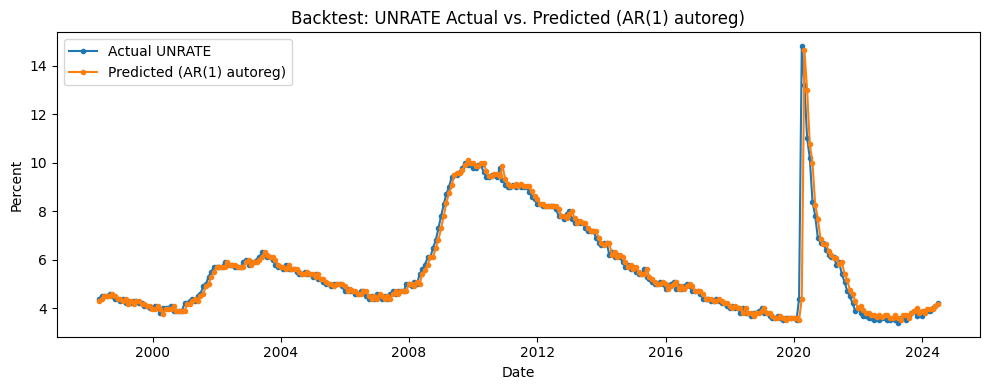

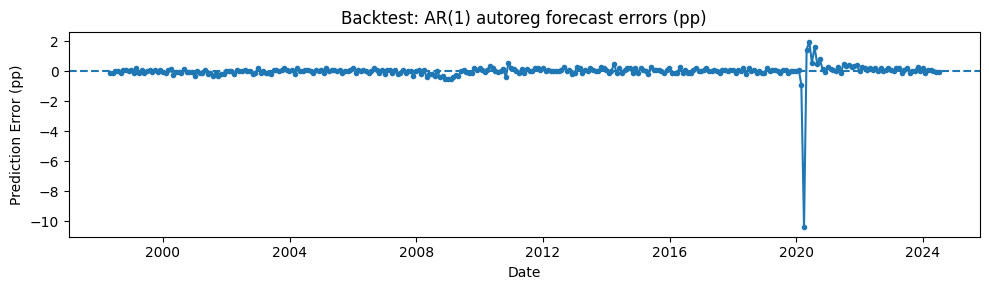

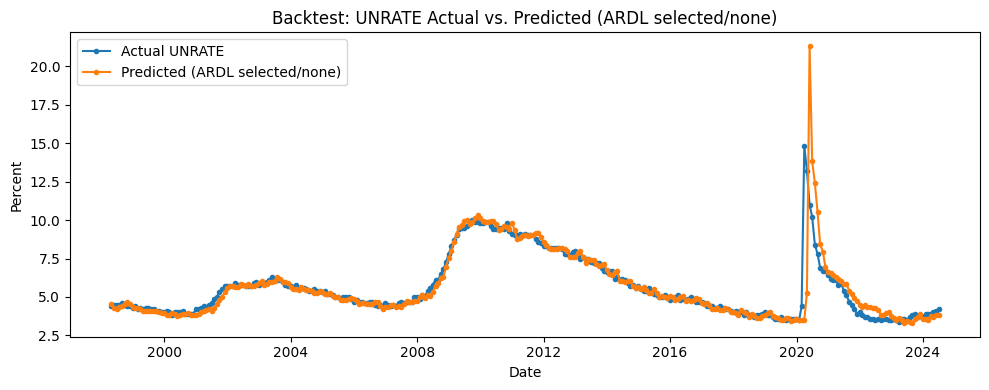

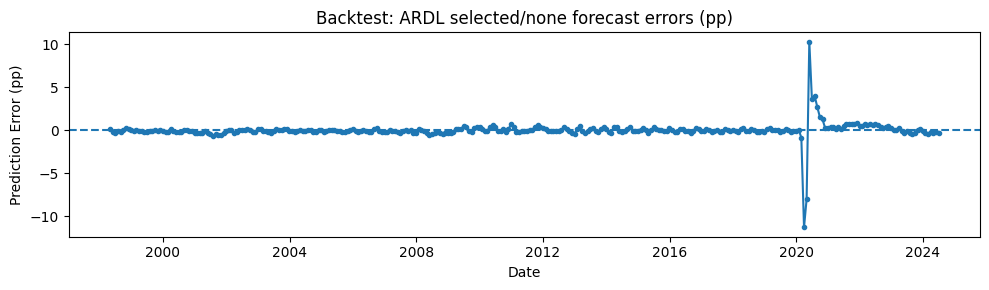

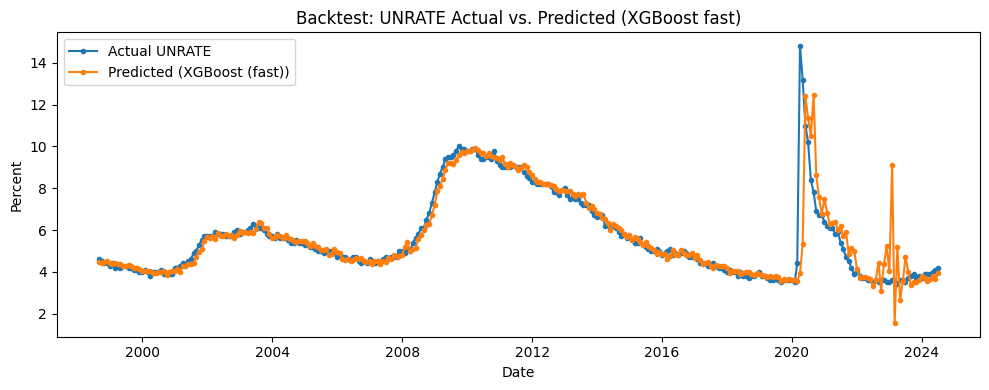

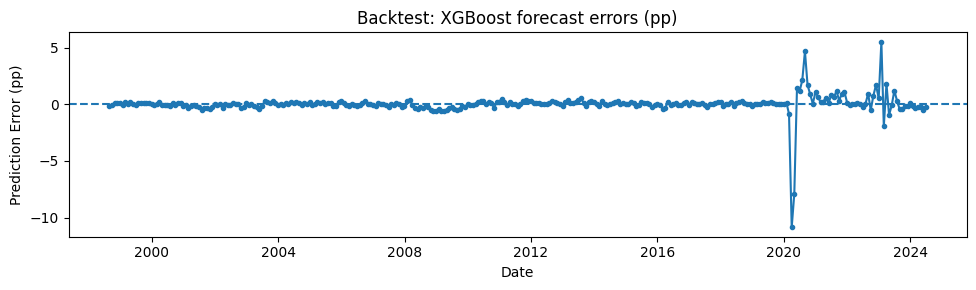

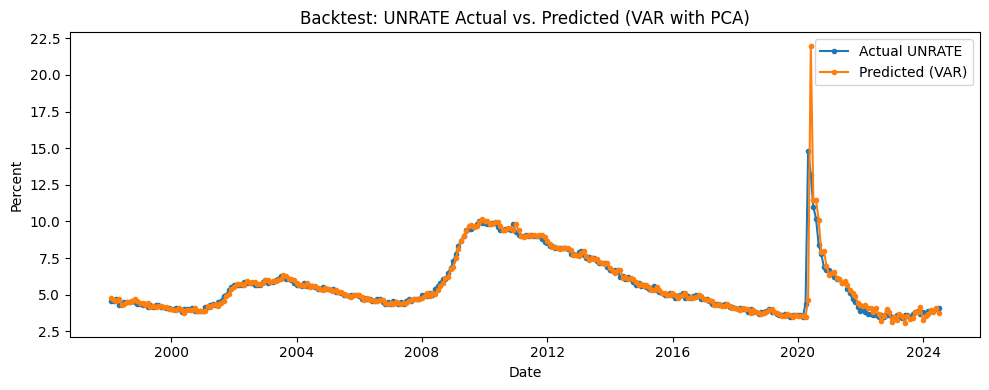

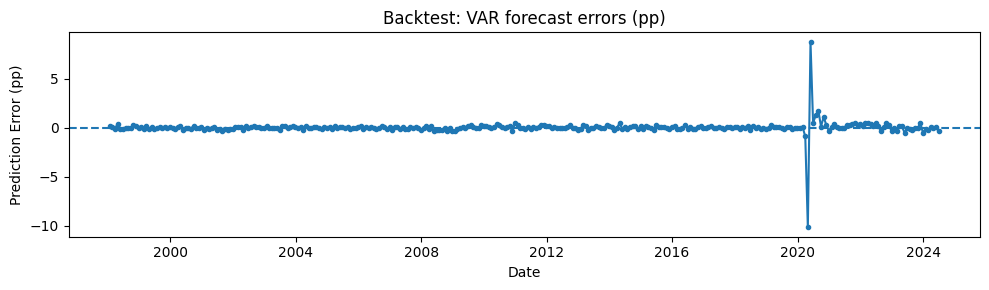


[14/18] Detecting shock months empirically from TRAIN backtests...
[DEBUG] ShockDetector summary
  - shock_method: residual_union
  - shock_z: 5.0
  - shock_k: 1
  - n_flagged_months: 18
  - flagged_months_sample: 2020-02, 2020-03, 2020-04, 2020-05, 2020-06, 2020-07
[DEBUG] Detected shock months (to exclude)
  - n: 18
  - months: 2020-02, 2020-03, 2020-04, 2020-05, 2020-06, 2020-07, 2020-08, 2020-09, 2020-10, 2020-12, 2021-08, 2021-11, 2022-11, 2023-01, 2023-02, 2023-03, 2023-04, 2023-06

[15/18] Fitting CV+ global conformal from TRAIN backtests (per model) with strategy...
[DEBUG] Calibration
  - strategy: time_filter
  - time_filter_source: auto_shock
  - shock_method: residual_union
  - shock_z: 5.0
  - shock_k: 1
  - winsor_cap: 
[DEBUG] CV+ AR(1)
  - mu: -0.022682292057584947
  - g: 0.12047345067470082
  - q: 2.795937703867312
[DEBUG] CV+ ARDL
  - mu: 0.005473447111398712
  - g: 0.22554255862898429
  - q: 2.4856040053347224
[DEBUG] CV+ XGB
  - mu: -0.021715242301237857
  - g: 0.1

,MAE,RMSE,R2,R2_OOS_vs_Naive,MASE,PI_Coverage,PI_Avg_Width
Model,,,,,,,
AR(1),0.083,0.097,-1.310,-0.420,1.246,1.000,0.674
ARDL,0.144,0.189,-7.679,-4.334,2.162,1.000,1.121
XGBoost,0.247,0.270,-16.768,-9.920,3.704,1.000,1.050
VAR,0.244,0.314,-23.446,-13.208,3.521,0.846,0.765


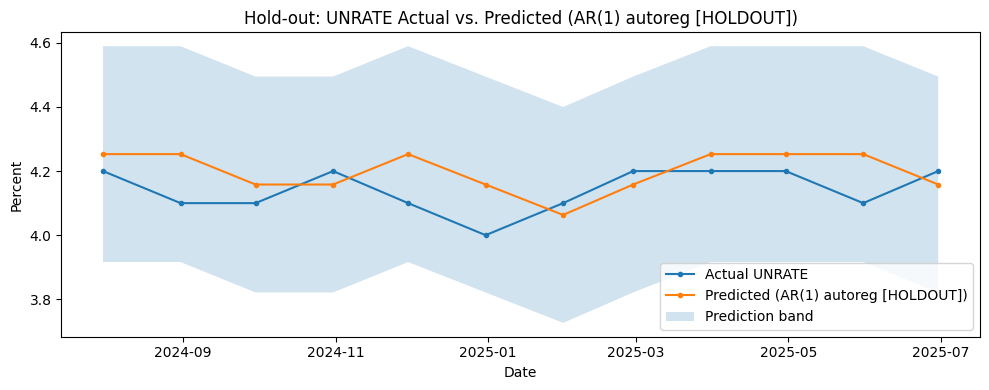

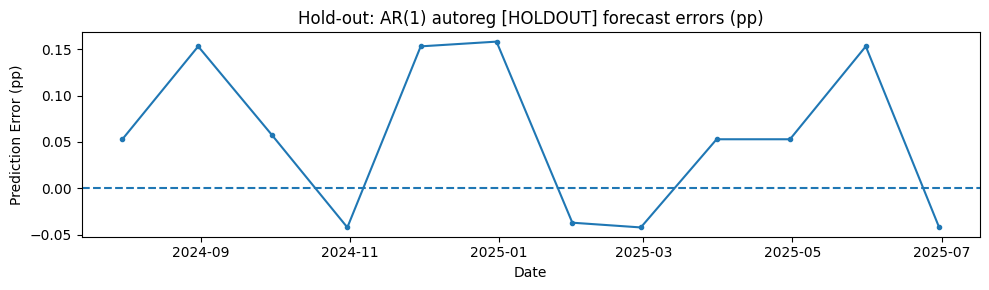

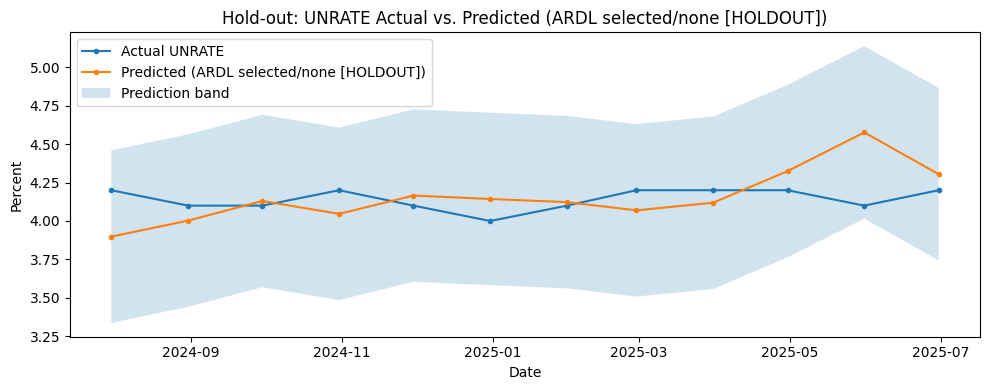

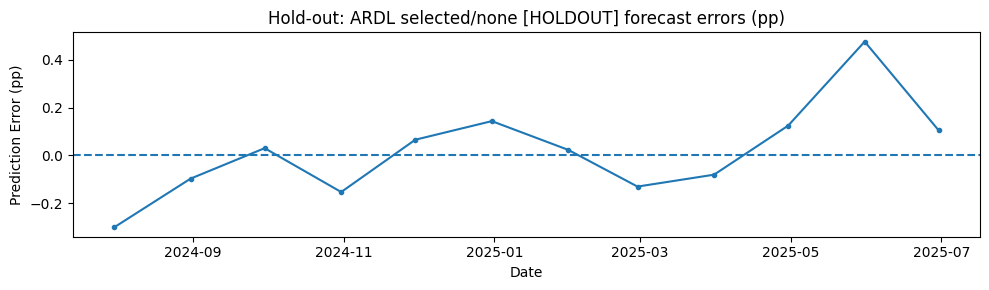

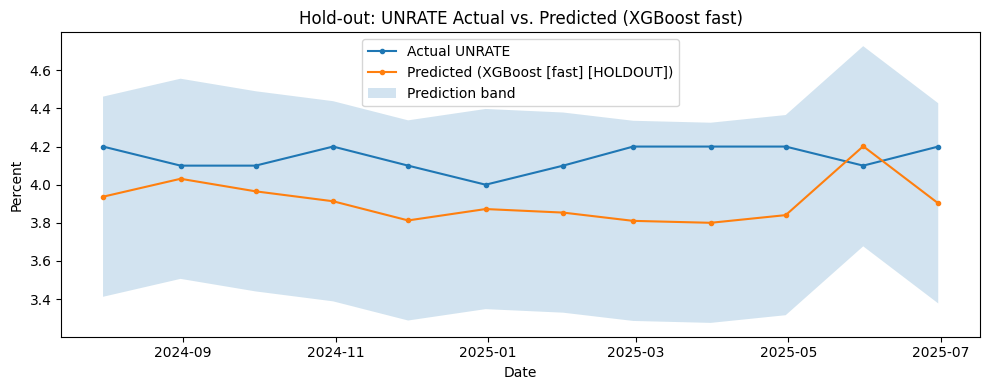

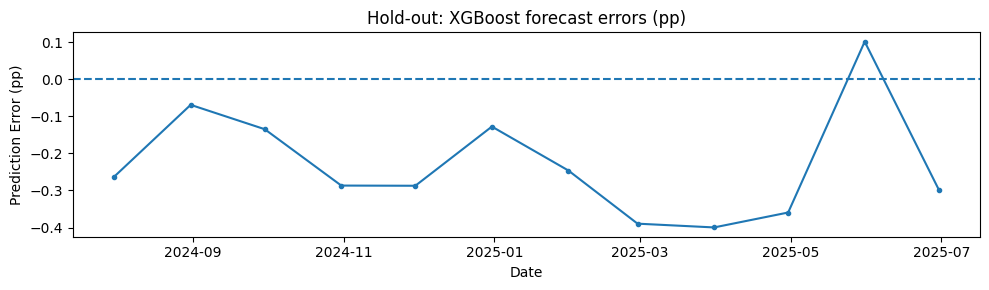

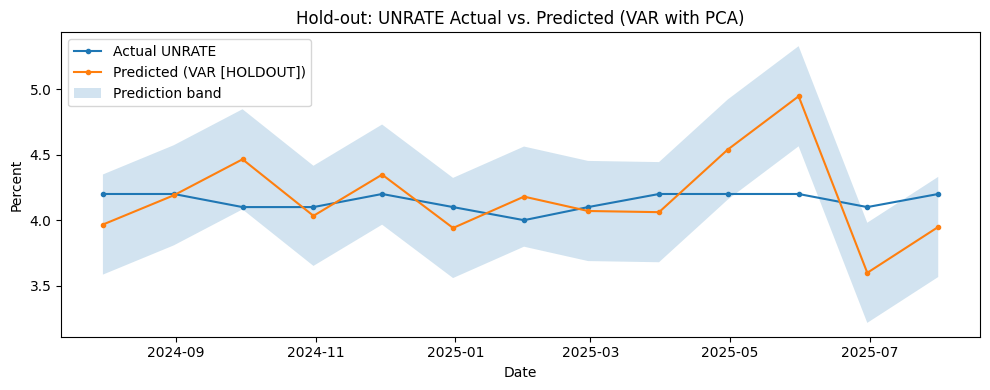

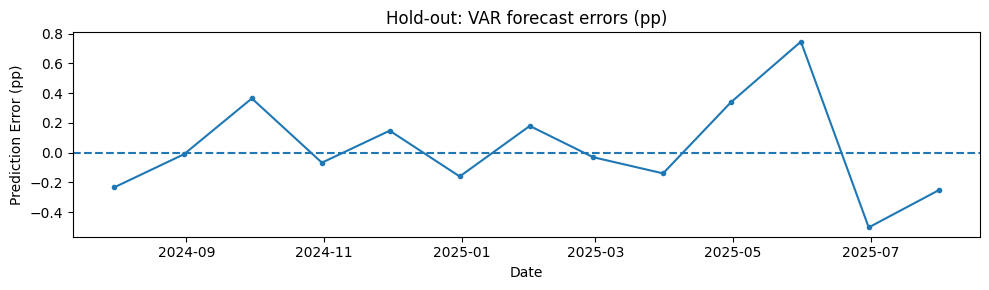


[18/18] Done. Figures saved in working directory.


In [24]:
if __name__ == "__main__":
    main()